## Import Libraries

In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

     |████████████████████████████████| 1.5MB 9.1MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 1.4 MB 8.9 MB/s 
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434676 sha256=49d9dd59c0a541f810f7d965612404a5b9cbd44f13ef0fa52a48444ae6e8ba29
  Stored in directory: /root/.cache/pip/wheels/de/5e/42/64abaeca668161c3e2cecc24f864a8fc421e3d07a104fc8a51
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 22.2 MB 1.8 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import joblib
from pathlib import Path
from google.colab import drive

import nltk
nltk.download('wordnet') 
nltk.download('rslp')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize   
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Dataset Import

In [ ]:
dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

In [ ]:
team_seed_number = 20

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1EA_pUIgK5Ub3kEzFbFl8wSRqAV6feHqD"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

## Α μέρος

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/ECE/roh_Y/9th_Neural_Networks/Lab2'
%cd "$path"

Mounted at /content/drive
/content/drive/MyDrive/ECE/roh_Y/9th_Neural_Networks/Lab2


In [ ]:
def save_file(name, obj):
  joblib.dump(obj, name+".pkl")

In [ ]:
def file_exists(name):
  file_path = Path(path+"/"+name+".pkl")
  return file_path.is_file()

In [ ]:
def load_file(name):
  return joblib.load(name+".pkl")

Για την προεπεξεργασία των δεδομένων μας, θα πραγματοποιήσουμε τα εξής:
* Αφαίρεση συντομογραφιών
* Lemmatization 

Οι παραπάνω τεχνικές μειώνουν το μέγεθος των διαστάσεων των features του TF-IDF, χωρίς να αφαιρούν σημαντική πληροφορία. Όλα αυτά που περιγράφονται, υλοποιούνται στην συνάρτηση `cleaning_curve()`.

In [ ]:
def cleaning_corpus(movie):
  movie = movie.lower()
  ab = { 
      "isn't" : "is not", "aren't" : "are not", "ain't" : "am not", "won't" : "will not",
      "didn't" : "did not","shan't" :  "shall not", "haven't" : "have not", "hadn't" : "had not",
      "don't" : "do not", "wasn't" : "was not", "weren't" : "were not", "doesn't" : "does not",
      "'s" : " is", "'re" : " are", "'m" :  " am", "'d" : " would", "'ll" : " will"
      } 
  ab = dict((re.escape(k), v) for k, v in ab.items())
  pattern = re.compile("|".join(ab.keys()))
  movie = pattern.sub(lambda m: ab[re.escape(m.group(0))], movie)

  #tokenizer
  word = nltk.word_tokenize(movie)
  
  filtered_words = [w for w in word if w not in stopwords.words('english') + list(string.punctuation)]
  #lemmatizer
  word_lem = WordNetLemmatizer()
  word_l = [word_lem.lemmatize(w) for w in filtered_words]
  
  word = ' '.join(w for w in word_l)
  return word

In [ ]:
corpus_cleaned = []
for i in corpus:
  corpus_cleaned.append(cleaning_corpus(i))

Δοκιμάζουμε τον `TfidfVectorizer()` μετά από την προεπεξεργασία των δεδομένων, αλλά χωρίς κάποια παράμετρο σαν όρισμα. Οι διαστάσεις παρατηρούμε ότι έχουν μειωθεί ελαφρώς.

In [ ]:
if file_exists("corpus_tf_idf_init"):
  corpus_tf_idf_init = load_file("corpus_tf_idf_init")
else: 
  vectorizer = TfidfVectorizer()
  vectorizer.fit(corpus_cleaned)
  corpus_tf_idf_init = vectorizer.transform(corpus_cleaned)
  save_file("corpus_tf_idf_init", corpus_tf_idf_init)
print("Dimensions of TfidfVectorizer() after preprocessing are: ", corpus_tf_idf_init.shape)

Dimensions of TfidfVectorizer() after preprocessing are:  (5000, 44252)


Η συνάρτηση `content_recommender ` έχει δύο ορίσματα `target_movie` και `max_recommendations`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (την σύνοψη) ταινίες, `max_recommendations` στο πλήθος. Έτσι, για κάθε ταινία-στόχο του `corpus_tf_idf` υπολογίζουμε την ομοιότητα συνημιτόνου της με όλες τις ταινίες της συλλογής μας. Κατόπιν, με βάση αυτή την ομοιότητα συνημιτόνου, δημιουργούμε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (ID) των ταινιών. Ακόμη, για την ταινία-στόχο εκτυπώνουμε ID, τίτλο, σύνοψη, κατηγορίες και για τις `max_recommendations` ταινίες τυπώνουμε με την σειρά σύστασης επίσης ID, τίτλο, σύνοψη και κατηγορίες. 

In [ ]:
def content_recommender(target_movie, max_recommendations, corpus_tf_idf):
    
    cosSimilarities = cosine_similarity(corpus_tf_idf_init[target_movie,:], corpus_tf_idf_init)
    #cosSimilarities[0]: get the similarities for our specified movie
    similarities_sorted = np.argsort(cosSimilarities[0])[::-1]
    
    print("TARGET MOVIE")
    print("ID: ", target_movie)
    print("TITLE: ", "".join(titles[target_movie]))
    print("SUMMARY: ", "".join(summaries[target_movie]))
    print("CATEGORIES: ", "".join(categories[target_movie]))
    print("********************************************************")
    print("********************************************************")
    for i in range(max_recommendations):
        recommend = similarities_sorted[i+1]
        print("RECOMMENDED MOVIE No ", i+1)
        print("ID: ", recommend)
        print("TITLE: ", "".join(titles[recommend]))
        print("SUMMARY: ", "".join(summaries[recommend]))
        print("CATEGORIES: ", "".join(categories[recommend]))
        print("SIMILARITY: ", cosSimilarities[0][recommend])
        print("-------------------------------------------------------")

Δοκιμάζουμε 3 διαφορετικές ταινίες για να έχουμε μια πιο αντικειμενική άποψη. 

In [ ]:
content_recommender(4773, 4, corpus_tf_idf_init)

TARGET MOVIE
ID:  4773
TITLE:  Call Me Claus
SUMMARY:   The movie starts as a flashback to Lucy Collins as a little girl. Her mother takes the kids to see a shopping mall Santa Claus, who happens to be the real one. Santa is nearing the end of his 200 year reign as St. Nick, and needs to find a replacement, someone who enjoys the Christmas season and it is shown from the heart. His search involves his hat and an elf assistant named Ralph . Nick puts the hat on every kid. If the hat glows, it means that person has the real Christmas spirit. He sees a lot of kids, and none of them glow. When Lucy sits on his lap, he puts the hat on her and it glows brightly, proving she'd make a good new Santa Claus, though&mdash;in this flashback&mdash;his reign still has 30–40 years to go. The movie returns to present day. It is Nick's last Christmas as Santa, and he must find Lucy again. He locates her in Los Angeles where she works as a network executive for the "Shop-A-Lot" Channel. She seems to hav

In [ ]:
content_recommender(4826, 4, corpus_tf_idf_init)

TARGET MOVIE
ID:  4826
TITLE:  The Girl Next Door
SUMMARY:   Ambitious Westport High School senior Matthew Kidman  dreams of a career in politics. He has been accepted to the prestigious Georgetown University, but will only be able to afford it if he can win a large scholarship. With graduation approaching, he struggles to find anything truly memorable about his high school experience which is quite hard due to his social staus. However, his luck changes when he meets his beautiful next door neighbor Danielle . The outlandish Danielle and the steady Matthew each turn out to be the perfect complement for the other, and they are immediately smitten with one another. However, the relationship is challenged when Matthew discovers through his porn-enthusiast friend, Eli , that Danielle recently was an adult film actress under the stage name "Athena". Following Eli's advice on how to deal with this incredible revelation, Matthew takes Danielle to a sleazy motel. Danielle guesses that Matthew

In [ ]:
content_recommender(4949, 4, corpus_tf_idf_init)

TARGET MOVIE
ID:  4949
TITLE:  Bonnie and Clyde
SUMMARY:  In the middle of the Great Depression, Clyde Barrow  and Bonnie Parker  meet when Clyde tries to steal Bonnie's mother's car. Bonnie, who is bored by her job as a waitress, is intrigued with Clyde, and decides to take up with him and become his partner in crime. They pull off some holdups, but their amateur efforts, while exciting, are not very lucrative. The duo's crime spree shifts into high gear once they hook up with a dim-witted gas station attendant, C.W. Moss , then with Clyde's older brother Buck  and his wife, Blanche , a preacher's daughter. The women dislike each other on first sight, and their feud only escalates from there: shrill Blanche has nothing but disdain for Bonnie, Clyde and C.W., while gun-moll Bonnie sees Blanche's flighty presence as a constant danger to the gang's well-being. Bonnie and Clyde turn from pulling small-time heists to robbing banks. Their exploits also become more violent. When C.W. botches

**Χωρίς** κάποιες **παραμέτρους** στον `TfidfVectorizer()`, παρατηρούμε ότι για τις 5 πρώτες πιο όμοιες ταίνιες, τα similarities τους με την αρχική ταινία που εξετάζουμε είναι **χαμηλές**. Αυτό το αποτέλεσμα δεν είναι το επιθυμητό.

Μεταβάλλουμε τις τιμές των παραμέτρων `ngram_range`, `stop_words`, `max_df` και `min_df` προκειμένου να δούμε ποιες θα κρατήσουμε. Δε θέλουμε ούτε να κρατήσουμε πολλές, διότι τότε θα καθυστερεί σημαντικά το recommendation system μας και είναι πιθανό να θεωρηθούν όμοιες ταινίες κάποιες που σημασιολογικά δεν είναι. Όμως, δεν θέλουμε ούτε λίγες, καθώς μπορεί να μη βρούμε ταινίες να προτείνουμε. Τα δύο άκρα είναι κακές πρακτικές για ένα recommendation system, οπότε πρέπει να κάνουμε δοκιμές για να δούμε τι ταιριάζει στο σύνολο ταινιών που διαθέτουμε. 



In [ ]:
vectorizer1_0 = TfidfVectorizer(ngram_range=(1,3), analyzer='word')
vectorizer1_0.fit(corpus_cleaned)
corpus_tf_idf1_0 = vectorizer1_0.transform(corpus_cleaned)
print("Dimensions are: ", corpus_tf_idf1_0.shape)
content_recommender(4773, 4, corpus_tf_idf1_0)

Dimensions are:  (5000, 1568241)
TARGET MOVIE
ID:  4773
TITLE:  Call Me Claus
SUMMARY:   The movie starts as a flashback to Lucy Collins as a little girl. Her mother takes the kids to see a shopping mall Santa Claus, who happens to be the real one. Santa is nearing the end of his 200 year reign as St. Nick, and needs to find a replacement, someone who enjoys the Christmas season and it is shown from the heart. His search involves his hat and an elf assistant named Ralph . Nick puts the hat on every kid. If the hat glows, it means that person has the real Christmas spirit. He sees a lot of kids, and none of them glow. When Lucy sits on his lap, he puts the hat on her and it glows brightly, proving she'd make a good new Santa Claus, though&mdash;in this flashback&mdash;his reign still has 30–40 years to go. The movie returns to present day. It is Nick's last Christmas as Santa, and he must find Lucy again. He locates her in Los Angeles where she works as a network executive for the "Shop

In [ ]:
vectorizer2_0 = TfidfVectorizer(ngram_range=(1,3), analyzer='word')
vectorizer2_0.fit(corpus_cleaned)
corpus_tf_idf2_0 = vectorizer2_0.transform(corpus_cleaned)
print("Dimensions are: ", corpus_tf_idf2_0.shape)
content_recommender(4826, 4, corpus_tf_idf2_0)

Dimensions are:  (5000, 1568241)
TARGET MOVIE
ID:  4826
TITLE:  The Girl Next Door
SUMMARY:   Ambitious Westport High School senior Matthew Kidman  dreams of a career in politics. He has been accepted to the prestigious Georgetown University, but will only be able to afford it if he can win a large scholarship. With graduation approaching, he struggles to find anything truly memorable about his high school experience which is quite hard due to his social staus. However, his luck changes when he meets his beautiful next door neighbor Danielle . The outlandish Danielle and the steady Matthew each turn out to be the perfect complement for the other, and they are immediately smitten with one another. However, the relationship is challenged when Matthew discovers through his porn-enthusiast friend, Eli , that Danielle recently was an adult film actress under the stage name "Athena". Following Eli's advice on how to deal with this incredible revelation, Matthew takes Danielle to a sleazy mot

In [ ]:
vectorizer3_0 = TfidfVectorizer(ngram_range=(1,3), analyzer='word')
vectorizer3_0.fit(corpus_cleaned)
corpus_tf_idf3_0 = vectorizer3_0.transform(corpus_cleaned)
print("Dimensions are: ", corpus_tf_idf3_0.shape)
content_recommender(4949, 4, corpus_tf_idf3_0)

Dimensions are:  (5000, 1568241)
TARGET MOVIE
ID:  4949
TITLE:  Bonnie and Clyde
SUMMARY:  In the middle of the Great Depression, Clyde Barrow  and Bonnie Parker  meet when Clyde tries to steal Bonnie's mother's car. Bonnie, who is bored by her job as a waitress, is intrigued with Clyde, and decides to take up with him and become his partner in crime. They pull off some holdups, but their amateur efforts, while exciting, are not very lucrative. The duo's crime spree shifts into high gear once they hook up with a dim-witted gas station attendant, C.W. Moss , then with Clyde's older brother Buck  and his wife, Blanche , a preacher's daughter. The women dislike each other on first sight, and their feud only escalates from there: shrill Blanche has nothing but disdain for Bonnie, Clyde and C.W., while gun-moll Bonnie sees Blanche's flighty presence as a constant danger to the gang's well-being. Bonnie and Clyde turn from pulling small-time heists to robbing banks. Their exploits also becom

Με την χρήση της παραμέτρου `ngram_arrange` στον `TfidfVectorizer()` παρατηρούμε ότι παρατηρούμε ότι για τις 4 πρώτες πιο όμοιες ταίνιες, τα similarities τους με την αρχική ταινία που εξετάζουμε είναι **ακόμα πιο χαμηλά** σε σχέση με τον προηγούμενο `TfidVectorizer()` που δεν είχε καμία παράμετρο. Ακόμα, παρατηρούμε ότι χρησιμοποιώντας αυτή τη παράμετρο αυξάνεται σε πολύ μεγάλο βαθμό το μέγεθος των διαστάσεων, το οποίο είναι μη επιθυμητό.

#### Ελέγχουμε την παράμετρο `stop_words`:

In [ ]:
vectorizer1_1 = TfidfVectorizer(stop_words='english', analyzer='word')
vectorizer1_1.fit(corpus_cleaned)
corpus_tf_idf1_1 = vectorizer1_1.transform(corpus_cleaned)
print("Dimensions are: ", corpus_tf_idf1_1.shape)
content_recommender(4773, 4, corpus_tf_idf1_1)

Dimensions are:  (5000, 43971)
TARGET MOVIE
ID:  4773
TITLE:  Call Me Claus
SUMMARY:   The movie starts as a flashback to Lucy Collins as a little girl. Her mother takes the kids to see a shopping mall Santa Claus, who happens to be the real one. Santa is nearing the end of his 200 year reign as St. Nick, and needs to find a replacement, someone who enjoys the Christmas season and it is shown from the heart. His search involves his hat and an elf assistant named Ralph . Nick puts the hat on every kid. If the hat glows, it means that person has the real Christmas spirit. He sees a lot of kids, and none of them glow. When Lucy sits on his lap, he puts the hat on her and it glows brightly, proving she'd make a good new Santa Claus, though&mdash;in this flashback&mdash;his reign still has 30–40 years to go. The movie returns to present day. It is Nick's last Christmas as Santa, and he must find Lucy again. He locates her in Los Angeles where she works as a network executive for the "Shop-A

In [ ]:
vectorizer2_1 = TfidfVectorizer(stop_words='english', analyzer='word')
vectorizer2_1.fit(corpus_cleaned)
corpus_tf_idf2_1 = vectorizer2_1.transform(corpus_cleaned)
print("Dimensions are: ", corpus_tf_idf2_1.shape)
content_recommender(4826, 4, corpus_tf_idf2_1)

Dimensions are:  (5000, 43971)
TARGET MOVIE
ID:  4826
TITLE:  The Girl Next Door
SUMMARY:   Ambitious Westport High School senior Matthew Kidman  dreams of a career in politics. He has been accepted to the prestigious Georgetown University, but will only be able to afford it if he can win a large scholarship. With graduation approaching, he struggles to find anything truly memorable about his high school experience which is quite hard due to his social staus. However, his luck changes when he meets his beautiful next door neighbor Danielle . The outlandish Danielle and the steady Matthew each turn out to be the perfect complement for the other, and they are immediately smitten with one another. However, the relationship is challenged when Matthew discovers through his porn-enthusiast friend, Eli , that Danielle recently was an adult film actress under the stage name "Athena". Following Eli's advice on how to deal with this incredible revelation, Matthew takes Danielle to a sleazy motel

In [ ]:
vectorizer3_1 = TfidfVectorizer(stop_words='english', analyzer='word')
vectorizer3_1.fit(corpus_cleaned)
corpus_tf_idf3_1 = vectorizer3_1.transform(corpus_cleaned)
print("Dimensions are: ", corpus_tf_idf3_1.shape)
content_recommender(4949, 4, corpus_tf_idf3_1)

Dimensions are:  (5000, 43971)
TARGET MOVIE
ID:  4949
TITLE:  Bonnie and Clyde
SUMMARY:  In the middle of the Great Depression, Clyde Barrow  and Bonnie Parker  meet when Clyde tries to steal Bonnie's mother's car. Bonnie, who is bored by her job as a waitress, is intrigued with Clyde, and decides to take up with him and become his partner in crime. They pull off some holdups, but their amateur efforts, while exciting, are not very lucrative. The duo's crime spree shifts into high gear once they hook up with a dim-witted gas station attendant, C.W. Moss , then with Clyde's older brother Buck  and his wife, Blanche , a preacher's daughter. The women dislike each other on first sight, and their feud only escalates from there: shrill Blanche has nothing but disdain for Bonnie, Clyde and C.W., while gun-moll Bonnie sees Blanche's flighty presence as a constant danger to the gang's well-being. Bonnie and Clyde turn from pulling small-time heists to robbing banks. Their exploits also become 

-------------------------

In [ ]:
stop_words = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'movie', 'film', 'plot', 'aaron', 'abbey', 'abbie', 'abdul', 'abe', 'across', 'abel', 'abigail', 'about', 'above', 'abraham', 'abram', 'abst', 'accordance', 'according', 'act', 'actually', 'ada', 'adah', 'adalberto', 'adaline', 'adam', 'adan', 'added', 'among', 'addie', 'adela', 'adelaida', 'adelaide', 'adele', 'adelia', 'adelina', 'adeline', 'adell', 'adella', 'adelle', 'adena', 'adina', 'adj', 'adolfo', 'adolph', 'adopted', 'adria', 'adrian', 'adriana', 'adriane', 'adrianna', 'adrien', 'adrienne', 'after', 'afterwards', 'afton', 'again', 'against', 'agatha', 'agnes', 'agnus', 'agueda', 'agustina', 'ahmad', 'ahmed', 'ai', 'aida', 'besides', 'aide', 'aiko', 'aileen', 'ailene', 'aimee', 'aja', 'akilah', 'al', 'alaina', 'alaine', 'alan', 'alana', 'alane', 'alanna', 'alayna', 'alba', 'albert', 'alberta', 'albertha', 'albertina', 'albertine', 'alberto', 'albina', 'alda', 'alden', 'aldo', 'alease', 'alec', 'alecia', 'e', 'aleen', 'aleisha', 'eg', 'alejandra', 'alejandrina', 'alejandro', 'alena', 'elsewhere', 'alene', 'alesha', 'aleshia', 'alesia', 'alessandra', 'aleta', 'aletha', 'everywhere', 'alethea', 'alethia', 'alex', 'alexander', 'alexandria', 'alexia', 'alexis', 'alfonso', 'alfonzo', 'alfred', 'alfreda', 'alfredia', 'alfredo', 'ali', 'alia', 'alica', 'alice', 'alicia', 'alida', 'alina', 'alisa', 'alise', 'had', 'alisha', 'alishia', 'alisia', 'alison', 'alissa', 'alita', 'alix', 'aliza', 'all', 'alla', 'allan', 'alleen', 'allegra', 'allen', 'allena', 'allene', 'allie', 'alline', 'allison', 'allyn', 'allyson', 'alma', 'hop', 'almeda', 'almeta', 'almost', 'alona', 'alone', 'along', 'alonso', 'alonzo', 'alpha', 'alphonse', 'alphonso', 'already', 'also', 'alta', 'altagracia', 'altha', 'althea', 'although', 'alton', 'alva', 'alvaro', 'alvera', 'alverta', 'alvin', 'alvina', 'always', 'alyce', 'alycia', 'alysa', 'alyse', 'alysha', 'alysia', 'alyson', 'alyssa', 'am', 'amado', 'amal', 'amalia', 'amanda', 'amber', 'amberly', 'ambrose', 'amee', 'amelia', 'long', 'america', 'm', 'ami', 'amie', 'amiee', 'amina', 'may', 'amira', 'ammie', 'amongst', 'amos', 'might', 'amparo', 'amy', 'an', 'ana', 'anabel', 'anamaria', 'anastacia', 'anastasia', 'and', 'andera', 'anderson', 'andra', 'andre', 'na', 'andrea', 'andreas', 'andres', 'andrew', 'andria', 'andy', 'anette', 'angel', 'angela', 'angele', 'angelena', 'angeles', 'angelia', 'angelic', 'angelica', 'angelina', 'angeline', 'angelique', 'angelita', 'angella', 'angelo', 'angelyn', 'angie', 'angila', 'angla', 'angle', 'anglea', 'anh', 'anibal', 'anika', 'anisha', 'anissa', 'anita', 'anitra', 'anjanette', 'anjelica', 'ann', 'anna', 'annabel', 'annabell', 'annabelle', 'overall', 'annalee', 'annalisa', 'annamae', 'annamaria', 'annamarie', 'anne', 'anneliese', 'annelle', 'annemarie', 'put', 'annetta', 'annice', 'annie', 'rather', 'annika', 'annis', 'annmarie', 'announce', 'another', 'answered', 'anthony', 'antione', 'antionette', 'antoine', 'anton', 'antone', 'antonetta', 'antonette', 'antonia', 'antonietta', 'antonina', 'antonio', 'antony', 'antwan', 'any', 'anya', 'anyhow', 'anyone', 'anything', 'anywhere', 'apolonia', 'april', 'apryl', 'ara', 'should', 'araceli', 'aracelis', 'aracely', 'arcelia', 'archie', 'ardath', 'ardelia', 'ardell', 'ardella', 'ardelle', 'arden', 'ardis', 'ardith', 'are', 'aren', 'arent', 'aretha', 'argelia', 'argentina', 'ariana', 'arianna', 'arianne', 'arica', 'arie', 'ariel', 'arielle', 'arla', 'arlean', 'arleen', 'arlen', 'there', 'arlena', 'arlene', 'arletha', 'arletta', 'arlette', 'arlie', 'arlinda', 'arline', 'arlyne', 'armand', 'armanda', 'they', 'armandina', 'armando', 'armida', 'arminda', 'arnetta', 'arnette', 'arnita', 'arnold', 'arnoldo', 'arnulfo', 'around', 'arron', 'three', 'art', 'arthur', 'artie', 'arturo', 'arvilla', 'as', 'asa', 'asha', 'ashanti', 'ashely', 'ashlea', 'toward', 'ashlee', 'ashleigh', 'ashley', 'ashli', 'ashlie', 'ashly', 'ashlyn', 'asia', 'ask', 'unlikely', 'asked', 'asley', 'assunta', 'astrid', 'ups', 'at', 'athena', 'aubrey', 'audie', 'audra', 'audrea', 'audrey', 'audria', 'audrie', 'audry', 'august', 'augusta', 'augustina', 'augustine', 'augustus', 'aundrea', 'aura', 'aurea', 'aurelia', 'aurelio', 'aurora', 'aurore', 'austin', 'auth', 'autumn', 'ava', 'available', 'avelina', 'avery', 'avis', 'avril', 'awilda', 'ayako', 'ayana', 'ayanna', 'ayesha', 'azalee', 'azucena', 'azzie', 'b', 'babara', 'babette', 'back', 'bailey', 'bambi', 'bao', 'barabara', 'barb', 'barbara', 'barbera', 'barbie', 'barbra', 'bari', 'barney', 'barrett', 'barrie', 'bart', 'basil', 'would', 'basilia', 'be', 'bea', 'beata', 'beatrice', 'beatris', 'beatriz', 'beau', 'beaulah', 'bebe', 'became', 'because', 'becki', 'becky', 'become', 'becomes', 'becoming', 'bee', 'abby', 'been', 'before', 'beforehand', 'begin', 'beginning', 'behind', 'being', 'belen', 'belia', 'belinda', 'belkis', 'bell', 'bella', 'belle', 'below', 'ben', 'benedict', 'benita', 'benito', 'benjamin', 'bennett', 'benny', 'benton', 'berenice', 'berna', 'bernadette', 'bernadine', 'bernard', 'bernarda', 'bernardina', 'bernardine', 'bernardo', 'adrianne', 'berneice', 'adriene', 'bernice', 'bernie', 'berniece', 'bernita', 'bert', 'agripina', 'berta', 'agustin', 'bertha', 'bertie', 'bertram', 'beryl', 'beside', 'bess', 'bessie', 'best', 'beth', 'bethanie', 'aisha', 'bethann', 'akiko', 'bethany', 'bethel', 'betsey', 'bette', 'better', 'bettie', 'bettina', 'betty', 'bettyann', 'bettye', 'between', 'beula', 'beulah', 'bev', 'beverlee', 'beverley', 'beverly', 'beyond', 'bianca', 'bibi', 'bill', 'billie', 'billy', 'billye', 'aleida', 'birdie', 'birgit', 'blaine', 'blair', 'blake', 'blanca', 'blanch', 'blanche', 'blondell', 'blossom', 'blythe', 'bo', 'bobbi', 'bobbie', 'bobbye', 'alexa', 'bok', 'alexandra', 'bong', 'bonita', 'bonnie', 'bonny', 'booker', 'boris', 'both', 'boyce', 'boyd', 'brad', 'bradford', 'bradley', 'bradly', 'brady', 'brain', 'branda', 'aline', 'brande', 'brandee', 'branden', 'brandi', 'brandon', 'brandy', 'brant', 'breana', 'breann', 'breanna', 'breanne', 'bree', 'brenda', 'brendan', 'brendon', 'brenna', 'brent', 'brenton', 'bret', 'brett', 'brian', 'briana', 'brianne', 'brice', 'bridget', 'bridgett', 'bridgette', 'brigette', 'brigid', 'brigida', 'brigitte', 'brinda', 'britany', 'britney', 'britni', 'britt', 'britta', 'brittaney', 'brittani', 'brittanie', 'britteny', 'brittni', 'brittny', 'brock', 'broderick', 'bronwyn', 'brook', 'brooke', 'brooks', 'bruce', 'amada', 'bruna', 'brunilda', 'bruno', 'bryan', 'bryanna', 'bryant', 'bryce', 'brynn', 'bryon', 'bud', 'buddy', 'buena', 'buffy', 'buford', 'bula', 'bunny', 'burl', 'burma', 'burt', 'burton', 'buster', 'but', 'analisa', 'by', 'byron', 'c', 'ca', 'caitlin', 'caitlyn', 'calandra', 'caleb', 'calista', 'andree', 'callie', 'calvin', 'camelia', 'camellia', 'cameron', 'camie', 'camila', 'camilla', 'camille', 'cammy', 'can', 'candace', 'candance', 'angelika', 'candelaria', 'candi', 'candice', 'candida', 'candis', 'candy', 'candyce', 'cannot', 'cant', 'caprice', 'caption', 'cara', 'caren', 'carey', 'cari', 'anisa', 'caridad', 'carie', 'carina', 'carisa', 'anja', 'carissa', 'carita', 'carl', 'carla', 'carlee', 'carleen', 'carlena', 'carlene', 'carletta', 'carley', 'carli', 'carline', 'carlita', 'carlo', 'carlos', 'carlota', 'annett', 'carlotta', 'annette', 'carlton', 'carly', 'carlyn', 'carma', 'annita', 'carman', 'carmel', 'carmela', 'carmelia', 'carmelina', 'antoinette', 'carmelita', 'carmella', 'carmelo', 'carmen', 'carmina', 'carmine', 'carmon', 'carol', 'carola', 'carolann', 'carole', 'carolee', 'carolin', 'caroline', 'caroll', 'carolyn', 'carolyne', 'carolynn', 'caron', 'caroyln', 'carri', 'carrie', 'carrol', 'carry', 'carson', 'cary', 'caryl', 'carylon', 'caryn', 'casandra', 'casey', 'casie', 'ariane', 'casimira', 'cassandra', 'cassaundra', 'cassey', 'cassidy', 'cassie', 'cassondra', 'cassy', 'catalina', 'catarina', 'caterina', 'catharine', 'catherin', 'catherina', 'catherine', 'cathern', 'catheryn', 'cathey', 'cathi', 'cathie', 'cathleen', 'cathrine', 'cathryn', 'cathy', 'catina', 'catrice', 'catrina', 'cayla', 'cecil', 'cecila', 'cecile', 'aron', 'cecilia', 'cecille', 'cecily', 'cedric', 'cedrick', 'celena', 'celesta', 'celeste', 'celestina', 'celestine', 'celia', 'celina', 'celinda', 'celine', 'celsa', 'ceola', 'cesar', 'chad', 'ashton', 'chadwick', 'chae', 'chan', 'chana', 'asuncion', 'chance', 'chanda', 'chandra', 'chanel', 'chanell', 'chanelle', 'chang', 'chantal', 'chantay', 'chante', 'chantel', 'chantell', 'chantelle', 'chapter', 'chara', 'charis', 'charise', 'charissa', 'charisse', 'charita', 'charity', 'charla', 'charlena', 'charlene', 'charles', 'charlesetta', 'charlette', 'charley', 'charlie', 'charline', 'charlott', 'charlotte', 'charlsie', 'charlyn', 'charmaine', 'charolette', 'chase', 'chasidy', 'chasity', 'chastity', 'chau', 'chauncey', 'chaya', 'barbar', 'chelsea', 'chelsey', 'chelsie', 'cher', 'chere', 'cheree', 'cherelle', 'cheri', 'barry', 'cherie', 'barton', 'cherilyn', 'cherish', 'cherlyn', 'cherri', 'cherrie', 'cherry', 'cherryl', 'chery', 'cheryl', 'cheryle', 'cheryll', 'beckie', 'chester', 'chet', 'cheyenne', 'chi', 'chia', 'chieko', 'chin', 'china', 'ching', 'belva', 'chiquita', 'chloe', 'chong', 'chris', 'chrissy', 'christa', 'bennie', 'christal', 'christeen', 'christel', 'christen', 'christene', 'christi', 'christia', 'christian', 'christiana', 'christiane', 'christie', 'christin', 'bernetta', 'christina', 'christine', 'christinia', 'christoper', 'berry', 'christopher', 'christy', 'chrystal', 'chu', 'chuck', 'chun', 'chung', 'cicely', 'ciera', 'cierra', 'cinda', 'cinderella', 'cindi', 'cindy', 'betsy', 'cinthia', 'cira', 'clair', 'clara', 'clare', 'clarence', 'claretha', 'claretta', 'claribel', 'clarice', 'clarine', 'claris', 'clarisa', 'clarissa', 'clarita', 'billi', 'clark', 'classie', 'claud', 'claude', 'claudette', 'claudia', 'claudie', 'claudine', 'claudio', 'clay', 'clayton', 'clemencia', 'clement', 'clemente', 'clementina', 'bob', 'clementine', 'clemmie', 'bobby', 'cleo', 'bobette', 'cleopatra', 'cleora', 'cleotilde', 'cleta', 'cletus', 'cleveland', 'cliff', 'clifford', 'clifton', 'clint', 'clinton', 'clora', 'clorinda', 'clotilde', 'clyde', 'co', 'codi', 'cody', 'colby', 'coleen', 'brandie', 'coleman', 'colene', 'coletta', 'colette', 'colin', 'colleen', 'collen', 'collene', 'collette', 'collin', 'columbus', 'come', 'concepcion', 'conception', 'concetta', 'concha', 'conchita', 'connie', 'brianna', 'conrad', 'constance', 'consuela', 'consuelo', 'contessa', 'cora', 'coral', 'coralee', 'coralie', 'corazon', 'cordelia', 'cordell', 'cordia', 'cordie', 'coreen', 'corene', 'coretta', 'corey', 'brittany', 'corie', 'brittney', 'corina', 'corine', 'corinna', 'corinne', 'corliss', 'cornelia', 'cornelius', 'cornell', 'corrie', 'corrin', 'corrina', 'corrine', 'corrinne', 'cortez', 'cortney', 'could', 'couldnt', 'courtney', 'buck', 'coy', 'craig', 'creola', 'cried', 'cris', 'criselda', 'bulah', 'crissy', 'crista', 'cristal', 'cristen', 'cristi', 'cristie', 'cristin', 'cristina', 'cristine', 'cristobal', 'cristopher', 'cristy', 'cruz', 'crysta', 'crystal', 'crystle', 'cuc', 'cami', 'curt', 'curtis', 'cyndi', 'cyndy', 'cammie', 'cynthia', 'cyril', 'cyrstal', 'cyrus', 'cythia', 'd', 'dacia', 'candie', 'dagmar', 'candra', 'dagny', 'dahlia', 'daina', 'daine', 'daisey', 'daisy', 'dakota', 'dale', 'dalene', 'carin', 'dalia', 'dalila', 'dallas', 'dalton', 'damaris', 'damian', 'damien', 'damion', 'damon', 'dan', 'dana', 'danae', 'dane', 'carlie', 'danelle', 'danette', 'dani', 'danial', 'danica', 'daniel', 'daniela', 'daniele', 'daniell', 'daniella', 'danielle', 'danika', 'danille', 'danilo', 'danita', 'dann', 'danna', 'dannette', 'dannie', 'dannielle', 'danny', 'danuta', 'danyel', 'danyell', 'danyelle', 'daphine', 'dara', 'darby', 'carolina', 'darcel', 'darcey', 'darci', 'darcie', 'darcy', 'darell', 'daren', 'daria', 'darin', 'dario', 'carroll', 'darius', 'darla', 'carter', 'darleen', 'darlena', 'darlene', 'darline', 'darnell', 'daron', 'darrel', 'darrell', 'darren', 'darrick', 'darrin', 'cassi', 'darron', 'darryl', 'darwin', 'daryl', 'date', 'dave', 'david', 'davida', 'davina', 'davis', 'dawn', 'dawna', 'dawne', 'dayle', 'dayna', 'daysi', 'deadra', 'dean', 'deana', 'deandra', 'deandre', 'deandrea', 'deane', 'deangelo', 'cecelia', 'deann', 'deanna', 'deanne', 'deb', 'debbi', 'debbie', 'debbra', 'debby', 'debera', 'debi', 'debora', 'deborah', 'debra', 'debrah', 'debroah', 'dede', 'dedra', 'dee', 'deeann', 'deeanna', 'deedee', 'deena', 'deetta', 'deidra', 'deidre', 'deirdre', 'deja', 'del', 'delana', 'delbert', 'delcie', 'delena', 'delfina', 'delia', 'delicia', 'delila', 'delilah', 'delinda', 'delisa', 'dell', 'della', 'delma', 'delmar', 'delmer', 'delmy', 'delois', 'charleen', 'deloise', 'delora', 'deloras', 'delores', 'deloris', 'delorse', 'delpha', 'delphia', 'delphine', 'delsie', 'delta', 'demarcus', 'charmain', 'demetra', 'demetria', 'chas', 'demetrice', 'demetrius', 'dena', 'chassidy', 'denae', 'deneen', 'denese', 'denice', 'denis', 'denise', 'denisha', 'denita', 'denna', 'dennis', 'dennise', 'denny', 'denver', 'denyse', 'cherise', 'deon', 'cherly', 'deonna', 'derek', 'derick', 'derrick', 'deshawn', 'desirae', 'desire', 'desiree', 'despina', 'dessie', 'destiny', 'detra', 'devin', 'devon', 'devona', 'devora', 'devorah', 'dewayne', 'dewey', 'dewitt', 'dexter', 'dia', 'diamond', 'dian', 'diana', 'diane', 'diann', 'dianna', 'christena', 'dianne', 'dick', 'did', 'didnt', 'diedra', 'diedre', 'diego', 'dierdre', 'digna', 'dillon', 'dimple', 'dina', 'dinah', 'dino', 'dinorah', 'dion', 'dione', 'dionna', 'dionne', 'ciara', 'dirk', 'divina', 'dixie', 'do', 'dodie', 'does', 'cindie', 'doesnt', 'dollie', 'dolly', 'dolores', 'claire', 'doloris', 'domenic', 'domenica', 'dominga', 'domingo', 'dominic', 'dominica', 'clarinda', 'dominick', 'dominique', 'dominque', 'domitila', 'domonique', 'don', 'dona', 'donald', 'donella', 'donetta', 'donette', 'dong', 'donita', 'donn', 'donna', 'donnell', 'clelia', 'donnetta', 'donnette', 'donnie', 'donny', 'donovan', 'dont', 'donte', 'donya', 'dora', 'dorathy', 'dorcas', 'doreatha', 'doreen', 'dorene', 'doretha', 'dorethea', 'doretta', 'dori', 'doria', 'dorian', 'dorie', 'dorinda', 'dorine', 'doris', 'dorla', 'cole', 'dorotha', 'dorothea', 'dorothy', 'dorris', 'dorsey', 'dortha', 'dorthea', 'dorthey', 'dorthy', 'dot', 'dotty', 'colton', 'doug', 'douglas', 'douglass', 'dovie', 'down', 'doyle', 'dreama', 'drew', 'drucilla', 'duane', 'dudley', 'dulcie', 'dung', 'during', 'dusti', 'dustin', 'dusty', 'dwana', 'dwayne', 'dwight', 'dylan', 'each', 'earl', 'earle', 'earlean', 'cori', 'earleen', 'earlene', 'earlie', 'earline', 'earnest', 'earnestine', 'eartha', 'easter', 'eboni', 'ebonie', 'ebony', 'echo', 'ed', 'edda', 'eddie', 'cory', 'eddy', 'edelmira', 'eden', 'edgardo', 'edie', 'edith', 'edmond', 'edmund', 'edmundo', 'edna', 'edra', 'edris', 'eduardo', 'edward', 'edwardo', 'edwin', 'edyth', 'edythe', 'effie', 'efrain', 'efren', 'ehtel', 'eight', 'eighty', 'eilene', 'either', 'ela', 'eladia', 'elaina', 'elaine', 'elana', 'elane', 'elanor', 'elayne', 'elba', 'elda', 'elden', 'eldon', 'eldora', 'eldridge', 'eleanor', 'eleanora', 'eleanore', 'elease', 'elena', 'elene', 'eleni', 'elenor', 'elenora', 'eleonor', 'eleonora', 'eleonore', 'elfreda', 'elfrieda', 'elfriede', 'eli', 'elia', 'eliana', 'elias', 'dania', 'elicia', 'elida', 'elidia', 'elijah', 'elina', 'elinor', 'elinore', 'elisa', 'elisabeth', 'elise', 'eliseo', 'elisha', 'elissa', 'eliz', 'eliza', 'elizabeth', 'elizbeth', 'elizebeth', 'dante', 'elke', 'ella', 'ellamae', 'ellan', 'ellen', 'daphne', 'ellena', 'elli', 'ellie', 'elliot', 'elliott', 'ellis', 'ellsworth', 'elly', 'ellyn', 'elma', 'elmer', 'elmira', 'elmo', 'elna', 'elnora', 'elodia', 'elois', 'eloisa', 'eloise', 'elouise', 'eloy', 'elroy', 'elsa', 'else', 'elsie', 'elsy', 'elton', 'elva', 'elvera', 'elvia', 'elvie', 'elvina', 'elvira', 'elvis', 'elwanda', 'elwood', 'elyse', 'elza', 'ema', 'emanuel', 'emelda', 'emelia', 'emelina', 'emeline', 'emely', 'emerald', 'emerita', 'emerson', 'emery', 'emiko', 'emil', 'emile', 'emilee', 'emilia', 'emilie', 'emilio', 'emily', 'emma', 'emmaline', 'emmanuel', 'emmie', 'emmitt', 'emmy', 'emogene', 'emory', 'ena', 'enda', 'enedina', 'deedra', 'enid', 'enoch', 'enola', 'enough', 'enrique', 'enriqueta', 'epifania', 'delaine', 'era', 'erasmo', 'eric', 'erica', 'erich', 'erick', 'ericka', 'erik', 'erika', 'erin', 'erinn', 'erlene', 'erlinda', 'erline', 'erma', 'ermelinda', 'erminia', 'erna', 'ernest', 'ernestina', 'ernestine', 'ernesto', 'ernie', 'errol', 'ervin', 'erwin', 'eryn', 'esmeralda', 'esperanza', 'essie', 'esteban', 'estefana', 'estela', 'estell', 'estella', 'estelle', 'ester', 'esther', 'estrella', 'etc', 'etha', 'ethan', 'denisse', 'ethel', 'ethelene', 'ethelyn', 'ethyl', 'etsuko', 'etta', 'ettie', 'eufemia', 'eugena', 'eugene', 'eugenia', 'eugenie', 'eugenio', 'eula', 'eulah', 'eulalia', 'desmond', 'eun', 'euna', 'eunice', 'eura', 'eusebia', 'eusebio', 'eustolia', 'evalyn', 'evan', 'evangelina', 'evangeline', 'eve', 'evelia', 'evelin', 'evelina', 'eveline', 'evelyn', 'evelyne', 'evelynn', 'even', 'ever', 'everett', 'everette', 'every', 'everyone', 'everything', 'evette', 'evia', 'evie', 'evita', 'evon', 'evonne', 'ewa', 'except', 'exie', 'ezekiel', 'ezequiel', 'ezra', 'f', 'fabian', 'fabiola', 'fae', 'fairy', 'faith', 'fallon', 'fannie', 'fanny', 'far', 'farah', 'farrah', 'fatima', 'fatimah', 'faustina', 'faustino', 'fausto', 'fawn', 'fay', 'faye', 'fe', 'felecia', 'felica', 'felice', 'felicia', 'felicidad', 'felicita', 'felicitas', 'felipa', 'felipe', 'felisa', 'felisha', 'felix', 'felton', 'ferdinand', 'fermin', 'fermina', 'fern', 'fernanda', 'fernande', 'fernando', 'ferne', 'few', 'fidel', 'fidela', 'fidelia', 'fifty', 'filiberto', 'filomena', 'fiona', 'first', 'five', 'flavia', 'fleta', 'fletcher', 'flo', 'flor', 'flora', 'florance', 'florence', 'florencia', 'florencio', 'florene', 'dottie', 'florentina', 'florentino', 'floretta', 'floria', 'florida', 'florinda', 'florine', 'drema', 'florrie', 'flossie', 'drusilla', 'floy', 'floyd', 'dulce', 'fonda', 'duncan', 'for', 'forest', 'former', 'formerly', 'dwain', 'forrest', 'forty', 'foster', 'dyan', 'found', 'four', 'fran', 'france', 'francene', 'frances', 'francesca', 'francesco', 'franchesca', 'francie', 'francina', 'francine', 'francis', 'francisca', 'francisco', 'francoise', 'frank', 'eda', 'frankie', 'franklyn', 'fransisca', 'fred', 'freda', 'edgar', 'fredda', 'freddie', 'edison', 'freddy', 'frederic', 'frederica', 'frederick', 'fredericka', 'fredia', 'fredric', 'fredrick', 'fredricka', 'freeda', 'freeman', 'edwina', 'freida', 'frida', 'frieda', 'fritz', 'from', 'fumiko', 'eileen', 'further', 'g', 'gabriel', 'gabriela', 'gabriele', 'gabriella', 'gabrielle', 'gail', 'gala', 'gale', 'elbert', 'galen', 'galina', 'garfield', 'garland', 'garnet', 'garnett', 'garret', 'garrett', 'garry', 'gary', 'gaston', 'gavin', 'gay', 'gaye', 'elenore', 'gayla', 'gayle', 'gaylene', 'gaylord', 'gaynell', 'gearldine', 'gema', 'gemma', 'gena', 'gene', 'genesis', 'geneva', 'genevie', 'genevieve', 'elin', 'genevive', 'genia', 'genie', 'genna', 'gennie', 'genny', 'genoveva', 'geoffrey', 'georgann', 'george', 'georgeann', 'elizabet', 'georgeanna', 'georgene', 'georgetta', 'georgette', 'georgia', 'georgiana', 'georgiann', 'georgianne', 'georgina', 'georgine', 'gerald', 'geraldine', 'geraldo', 'geralyn', 'gerard', 'gerardo', 'gerda', 'geri', 'german', 'gerri', 'gerry', 'gertie', 'gertrude', 'gertrudis', 'get', 'ghislaine', 'gia', 'gianna', 'gidget', 'gigi', 'gilbert', 'gilberte', 'gilberto', 'gilda', 'gillian', 'gilma', 'gina', 'ginette', 'ginger', 'elvin', 'ginny', 'gino', 'giovanna', 'giovanni', 'gisela', 'gisele', 'giselle', 'gita', 'giuseppe', 'giuseppina', 'gladis', 'glady', 'gladys', 'glayds', 'glen', 'glenda', 'glendora', 'glenn', 'glenna', 'glennie', 'glennis', 'glinda', 'gloria', 'glory', 'glynda', 'glynis', 'go', 'golda', 'golden', 'emmett', 'goldie', 'gonzalo', 'good', 'gordon', 'got', 'grace', 'gracia', 'gracie', 'eneida', 'graciela', 'grady', 'graham', 'grant', 'granville', 'grayce', 'grazyna', 'great', 'gregg', 'gregoria', 'gregorio', 'gregory', 'greta', 'gretchen', 'gretta', 'gricelda', 'grisel', 'griselda', 'guadalupe', 'gudrun', 'guillermina', 'guillermo', 'gus', 'gussie', 'gustavo', 'guy', 'gwen', 'gwenda', 'gwendolyn', 'gwenn', 'gwyn', 'gwyneth', 'h', 'ha', 'hae', 'hai', 'esta', 'hailey', 'hal', 'haley', 'halina', 'halley', 'hallie', 'han', 'hang', 'hanh', 'hank', 'hanna', 'hannah', 'hannelore', 'hans', 'harlan', 'harland', 'harley', 'harmony', 'harold', 'harriet', 'harriett', 'harriette', 'harris', 'harrison', 'harry', 'harvey', 'has', 'hasnt', 'hassan', 'hassie', 'hattie', 'have', 'havent', 'haydee', 'eva', 'hayden', 'hayley', 'haywood', 'hazel', 'he', 'heath', 'heather', 'hector', 'hed', 'hedwig', 'hedy', 'heide', 'heidi', 'heidy', 'heike', 'helaine', 'helen', 'helena', 'helene', 'helga', 'hellen', 'hence', 'henrietta', 'henriette', 'henry', 'her', 'herb', 'herbert', 'here', 'hereafter', 'hereby', 'herein', 'heres', 'hereupon', 'herlinda', 'herma', 'herman', 'hermelinda', 'hermina', 'hermine', 'faviola', 'herminia', 'hers', 'herschel', 'herself', 'federico', 'hershel', 'hertha', 'hes', 'hester', 'hettie', 'hid', 'hien', 'hilaria', 'hilario', 'hilary', 'hilda', 'hildegard', 'hildred', 'hillary', 'hilma', 'hilton', 'him', 'himself', 'hipolito', 'hiroko', 'his', 'hoa', 'hobert', 'holley', 'holli', 'hollie', 'holly', 'home', 'homer', 'honey', 'hong', 'hope', 'horace', 'horacio', 'hortencia', 'hortense', 'hortensia', 'hosea', 'houston', 'how', 'howard', 'however', 'hoyt', 'hubert', 'huey', 'hugh', 'hui', 'hulda', 'humberto', 'hundred', 'hung', 'hunter', 'huong', 'hwa', 'hye', 'hyman', 'hyo', 'hyon', 'i', 'ian', 'id', 'ida', 'idalia', 'idell', 'idella', 'ie', 'iesha', 'if', 'ignacio', 'franklin', 'ike', 'ilana', 'ileana', 'ileen', 'ilene', 'iliana', 'ill', 'illa', 'ilona', 'ilse', 'iluminada', 'im', 'ima', 'imelda', 'imogene', 'in', 'inc', 'include', 'includes', 'indeed', 'index', 'india', 'indira', 'inell', 'ines', 'inez', 'information', 'inga', 'inge', 'ingeborg', 'inger', 'ingrid', 'inocencia', 'instead', 'internet', 'into', 'iola', 'iona', 'garth', 'ione', 'iraida', 'irena', 'irene', 'iris', 'irish', 'irma', 'irmgard', 'irvin', 'irving', 'gaynelle', 'is', 'isa', 'isaac', 'isabel', 'genaro', 'isabell', 'isabella', 'isadora', 'isaiah', 'isaias', 'isaura', 'isela', 'isiah', 'isidra', 'isidro', 'isis', 'ismael', 'isnt', 'isobel', 'israel', 'isreal', 'issac', 'it', 'its', 'itself', 'ivan', 'ivana', 'ive', 'georgianna', 'ivelisse', 'georgie', 'ivey', 'ivonne', 'ivory', 'ivy', 'izetta', 'izola', 'j', 'ja', 'jacalyn', 'jacelyn', 'germaine', 'jacinda', 'jacinta', 'jacinto', 'gertha', 'jackeline', 'gertrud', 'jackelyn', 'jacki', 'gertude', 'jackie', 'jacklyn', 'jackqueline', 'jackson', 'jaclyn', 'gil', 'jacob', 'jacqualine', 'jacque', 'jacquelin', 'jacqueline', 'jacquelyne', 'jacquelynn', 'jacques', 'jacquetta', 'jacqui', 'jacquie', 'jacquiline', 'jacquline', 'jacqulyn', 'jada', 'jadwiga', 'jae', 'jaime', 'jaimee', 'jaimie', 'jake', 'jaleesa', 'jalisa', 'jama', 'jamaal', 'jamal', 'jamar', 'jame', 'jamee', 'jamel', 'james', 'jamey', 'jami', 'jamie', 'jamika', 'jamila', 'jamison', 'jammie', 'jan', 'jana', 'janae', 'janay', 'jane', 'janean', 'janee', 'janeen', 'graig', 'janel', 'janell', 'janella', 'janelle', 'greg', 'janene', 'janessa', 'janet', 'janeth', 'janett', 'janetta', 'janette', 'janey', 'jani', 'janice', 'grover', 'janie', 'janina', 'janine', 'janis', 'janise', 'janita', 'jann', 'janna', 'jannet', 'jannette', 'jannie', 'january', 'janyce', 'jaqueline', 'jaquelyn', 'jared', 'jarod', 'jarred', 'jarrett', 'jarrod', 'jarvis', 'jasmin', 'jason', 'jasper', 'hana', 'jaunita', 'javier', 'jay', 'jaye', 'jayme', 'jaymie', 'jayna', 'jayne', 'jayson', 'jazmin', 'jazmine', 'jc', 'jean', 'jeana', 'jeane', 'jeanelle', 'jeanene', 'jeanett', 'jeanetta', 'jeanette', 'jeanice', 'jeanie', 'jeanine', 'jeanmarie', 'jeanna', 'jeanne', 'jeannetta', 'jeannette', 'jeannie', 'jeannine', 'jed', 'jeff', 'hee', 'jefferey', 'jefferson', 'jeffery', 'jeffie', 'jeffrey', 'jeffry', 'jen', 'jena', 'jenae', 'jene', 'jenee', 'jenell', 'jenelle', 'jenette', 'jeneva', 'heriberto', 'jeni', 'jenice', 'jenifer', 'jeniffer', 'hermila', 'jenine', 'jenise', 'jenna', 'jennefer', 'jennell', 'herta', 'jennette', 'jenni', 'jennie', 'hiedi', 'jennifer', 'jenniffer', 'jennine', 'jerald', 'jeraldine', 'hilde', 'jeramy', 'hildegarde', 'jere', 'jeremiah', 'jeri', 'jerica', 'jerilyn', 'hiram', 'jermaine', 'hisako', 'jerold', 'jerome', 'jeromy', 'jerrell', 'jerri', 'hollis', 'jerrica', 'jerrie', 'jerrod', 'jerrold', 'jerry', 'jesica', 'jess', 'jesse', 'jessenia', 'jessi', 'jessia', 'jessica', 'jessika', 'jestine', 'hsiu', 'jesus', 'hue', 'jesusa', 'jesusita', 'hugo', 'jetta', 'jettie', 'jewel', 'jewell', 'ji', 'jill', 'jillian', 'hyacinth', 'jim', 'jimmie', 'jin', 'jina', 'hyun', 'jinny', 'jo', 'joan', 'joana', 'joane', 'joann', 'ignacia', 'joanna', 'joanne', 'ila', 'joannie', 'ilda', 'joaquin', 'joaquina', 'jocelyn', 'jodee', 'jodi', 'jodie', 'jody', 'joeann', 'joel', 'joella', 'joelle', 'joellen', 'ina', 'joesph', 'joetta', 'joette', 'joey', 'johana', 'johanna', 'johanne', 'john', 'johna', 'johnathan', 'johnathon', 'johnetta', 'johnie', 'johnna', 'ira', 'johnnie', 'johnny', 'johnsie', 'irina', 'johnson', 'joi', 'joie', 'jolanda', 'joleen', 'jolene', 'irwin', 'jolie', 'joline', 'jolyn', 'jolynn', 'jon', 'isabelle', 'jona', 'jonah', 'jonas', 'jonathon', 'jone', 'jonell', 'jonelle', 'jong', 'joni', 'jonie', 'jonna', 'jonnie', 'jordan', 'jordon', 'iva', 'jorge', 'jose', 'josef', 'ivette', 'josefa', 'josefina', 'josefine', 'joselyn', 'joseph', 'josephina', 'josephine', 'josette', 'josh', 'joshua', 'josiah', 'josie', 'jack', 'joslyn', 'jospeh', 'josphine', 'josue', 'jovan', 'joy', 'joya', 'joyce', 'joycelyn', 'joye', 'juan', 'juana', 'juanita', 'jacquelyn', 'jude', 'judi', 'judie', 'judith', 'judson', 'judy', 'julee', 'julene', 'jules', 'juli', 'jade', 'julia', 'julian', 'juliana', 'juliane', 'juliann', 'julianna', 'julianne', 'julie', 'julieann', 'julienne', 'juliet', 'julieta', 'julietta', 'juliette', 'julio', 'julissa', 'julius', 'june', 'jung', 'junie', 'junior', 'junita', 'junko', 'just', 'justa', 'justina', 'justine', 'jutta', 'k', 'ka', 'kacey', 'kaci', 'kacie', 'kacy', 'kai', 'kaila', 'kaitlin', 'kaitlyn', 'kala', 'kaleigh', 'kaley', 'kali', 'kallie', 'kalyn', 'kam', 'kamala', 'janiece', 'kami', 'kamilah', 'kandace', 'kandice', 'kandis', 'kandra', 'kandy', 'kanesha', 'kanisha', 'kara', 'karan', 'kareem', 'kareen', 'karen', 'karena', 'karey', 'kari', 'karie', 'karima', 'karin', 'karina', 'jasmine', 'karine', 'karisa', 'karissa', 'karl', 'karla', 'karleen', 'karlene', 'karly', 'karlyn', 'karma', 'karmen', 'karol', 'karole', 'karoline', 'karolyn', 'karon', 'karren', 'karri', 'karrie', 'karry', 'kary', 'karyl', 'karyn', 'kasandra', 'kasha', 'kasi', 'kassandra', 'kassie', 'kate', 'katelin', 'katelyn', 'katelynn', 'katerine', 'kathaleen', 'katharina', 'katharine', 'katharyn', 'kathe', 'katheleen', 'katherin', 'katherine', 'kathern', 'kathey', 'kathi', 'kathie', 'kathleen', 'kathlene', 'kathline', 'kathlyn', 'kathrin', 'kathrine', 'kathryn', 'kathryne', 'kathy', 'kathyrn', 'kati', 'katia', 'katie', 'katlyn', 'katrice', 'katrina', 'kattie', 'katy', 'kay', 'jenny', 'kayce', 'kaycee', 'kaye', 'kayla', 'kaylee', 'jeremy', 'kayleen', 'kayleigh', 'kaylene', 'jerlene', 'kazuko', 'kecia', 'keeley', 'keely', 'keena', 'keesha', 'keiko', 'keila', 'keira', 'keisha', 'keith', 'jesenia', 'keitha', 'keli', 'kelle', 'kelley', 'kelli', 'kellie', 'kelly', 'jessie', 'kellye', 'kelsey', 'kelsi', 'kelsie', 'kelvin', 'kemberly', 'ken', 'kena', 'kenda', 'kendal', 'kendall', 'kendra', 'kendrick', 'keneth', 'jimmy', 'kenia', 'kenisha', 'kenna', 'kenneth', 'kenny', 'kent', 'kenton', 'joanie', 'kenyatta', 'kenyetta', 'kera', 'keren', 'keri', 'kermit', 'kerri', 'kerrie', 'kerry', 'kerstin', 'kesha', 'joe', 'keshia', 'keturah', 'keva', 'keven', 'kevin', 'khadijah', 'khalilah', 'kia', 'kiana', 'kiara', 'kiera', 'kiersten', 'kiesha', 'kieth', 'kim', 'kimber', 'kimberlee', 'johnette', 'kimberley', 'kimberlie', 'kimberly', 'kimbery', 'kimbra', 'kimi', 'kimiko', 'kina', 'kindra', 'king', 'kira', 'kirby', 'kirk', 'kirsten', 'kirstie', 'kirstin', 'kisha', 'kit', 'kittie', 'jonathan', 'kitty', 'kiyoko', 'kizzie', 'kizzy', 'klara', 'know', 'korey', 'kori', 'kortney', 'kory', 'kourtney', 'kraig', 'kris', 'krishna', 'krissy', 'krista', 'kristal', 'kristan', 'kristeen', 'kristel', 'kristen', 'kristi', 'kristian', 'kristie', 'kristin', 'kristina', 'kristine', 'kristofer', 'kristy', 'kristyn', 'krysta', 'jovita', 'krystal', 'krysten', 'krystin', 'krystina', 'krystle', 'krystyna', 'kum', 'kurt', 'kurtis', 'kyla', 'kyle', 'kylee', 'kylie', 'kym', 'jule', 'kymberly', 'kyoko', 'kyong', 'kyra', 'kyung', 'l', 'lacey', 'lachelle', 'laci', 'lacie', 'lacresha', 'lacy', 'ladawn', 'ladonna', 'lady', 'lael', 'lahoma', 'lai', 'laine', 'lajuana', 'lakeesha', 'lakeisha', 'lakendra', 'lakenya', 'lakesha', 'lakeshia', 'lakia', 'lakiesha', 'justin', 'lakisha', 'lakita', 'lala', 'lamonica', 'lamont', 'lan', 'lana', 'lance', 'landon', 'lane', 'lanell', 'lanelle', 'lanette', 'lani', 'lanie', 'lanita', 'lannie', 'lanny', 'lanora', 'laquanda', 'laquita', 'lara', 'larae', 'kandi', 'laraine', 'laree', 'larhonda', 'larisa', 'larissa', 'larita', 'laronda', 'larraine', 'larry', 'larue', 'lasandra', 'lashanda', 'lashandra', 'lashaun', 'lashaunda', 'lashawn', 'lashawna', 'lashay', 'lashell', 'lashon', 'lashonda', 'lashunda', 'last', 'latanya', 'latasha', 'latashia', 'later', 'latesha', 'latia', 'laticia', 'latina', 'latisha', 'latonia', 'latonya', 'latoria', 'latosha', 'latoya', 'latoyia', 'latrice', 'latricia', 'latrina', 'latrisha', 'kasey', 'latter', 'latterly', 'kasie', 'launa', 'laura', 'lauralee', 'lauran', 'laure', 'laureen', 'laurel', 'lauren', 'laurena', 'laurence', 'laurene', 'lauretta', 'laurette', 'lauri', 'katherina', 'laurice', 'laurie', 'katheryn', 'laurinda', 'laurine', 'lauryn', 'lavada', 'lavelle', 'lavenia', 'lavera', 'lavern', 'laverna', 'laverne', 'laveta', 'lavette', 'lavinia', 'lavon', 'lavona', 'lavonda', 'katina', 'lavone', 'lavonia', 'lavonna', 'lawana', 'lawanda', 'lawanna', 'lawerence', 'lawrence', 'layla', 'layne', 'lazaro', 'le', 'lea', 'leah', 'lean', 'leana', 'leandra', 'leandro', 'leann', 'keenan', 'leanna', 'leanne', 'leanora', 'least', 'leatha', 'leatrice', 'lecia', 'leda', 'leeann', 'kellee', 'leeanna', 'leeanne', 'leena', 'leesa', 'left', 'leia', 'leida', 'leif', 'leigh', 'leigha', 'leighann', 'leila', 'leilani', 'leisa', 'leisha', 'lekisha', 'lela', 'lelah', 'leland', 'lelia', 'lemuel', 'len', 'kennith', 'lena', 'lenard', 'lenita', 'kenya', 'lenna', 'lennie', 'lenny', 'lenora', 'lenore', 'leo', 'leola', 'leoma', 'leon', 'leona', 'leonard', 'leonarda', 'leonardo', 'leone', 'leonel', 'leonia', 'leonida', 'leonie', 'leonila', 'leonor', 'leonora', 'leonore', 'leontine', 'leopoldo', 'leora', 'kiley', 'leota', 'lera', 'kimberely', 'leroy', 'les', 'kimberli', 'lesa', 'lesha', 'lesia', 'leslee', 'lesley', 'lesli', 'leslie', 'less', 'lessie', 'kip', 'lester', 'let', 'leta', 'letha', 'leticia', 'letisha', 'letitia', 'lets', 'lettie', 'letty', 'levi', 'lewis', 'lezlie', 'li', 'lia', 'liana', 'liane', 'lianne', 'libbie', 'libby', 'liberty', 'librada', 'lida', 'lidia', 'lien', 'lieselotte', 'ligia', 'like', 'likely', 'lila', 'lili', 'lilia', 'lilian', 'liliana', 'lilla', 'kristle', 'lilli', 'kristopher', 'lillia', 'lilliam', 'lillian', 'lilliana', 'lillie', 'lilly', 'lily', 'lin', 'lina', 'lincoln', 'linda', 'lindsay', 'lindsey', 'lindsy', 'lindy', 'line', 'linette', 'ling', 'linh', 'links', 'linn', 'linnea', 'linnie', 'lino', 'linsey', 'linwood', 'lionel', 'lisa', 'lisabeth', 'lisandra', 'lisbeth', 'lise', 'lisette', 'lisha', 'laila', 'lissa', 'lissette', 'lita', 'livia', 'liz', 'liza', 'lizabeth', 'lizbeth', 'lizeth', 'lizette', 'lizzette', 'lizzie', 'll', 'lamar', 'lloyd', 'loan', 'logan', 'loida', 'lois', 'lola', 'lolita', 'loma', 'lon', 'lona', 'lang', 'londa', 'loni', 'lonna', 'lonnie', 'lonny', 'lora', 'loraine', 'loralee', 'lore', 'lorean', 'loree', 'loreen', 'lorelei', 'loren', 'lorena', 'lorene', 'lorenza', 'lorenzo', 'loreta', 'loretta', 'lorette', 'lori', 'loria', 'loriann', 'lorie', 'lorilee', 'lashawnda', 'lorinda', 'loris', 'lorita', 'lorna', 'lorraine', 'lasonya', 'lorretta', 'latarsha', 'lorri', 'lorriane', 'lorrie', 'lorrine', 'lory', 'lottie', 'lou', 'louanne', 'louella', 'louetta', 'louie', 'louis', 'louisa', 'louise', 'loura', 'lourdes', 'lourie', 'love', 'lovella', 'lovetta', 'lovie', 'lowell', 'loyce', 'loyd', 'ltd', 'lu', 'luana', 'luann', 'luanna', 'luanne', 'luba', 'lucas', 'luci', 'lucia', 'luciano', 'lucie', 'lucien', 'lucienne', 'lucila', 'lucilla', 'lucille', 'lucina', 'lucio', 'lucius', 'lucrecia', 'lavina', 'lucretia', 'lucy', 'ludie', 'ludivina', 'luella', 'luetta', 'luigi', 'lavonne', 'luis', 'luisa', 'luise', 'luke', 'lula', 'lulu', 'luna', 'lupe', 'lupita', 'lura', 'lurlene', 'lurline', 'luther', 'luvenia', 'luz', 'lyda', 'lydia', 'lyla', 'lyle', 'lyman', 'lyn', 'lynda', 'lyndia', 'lee', 'lyndon', 'lyndsay', 'lyndsey', 'lynell', 'lynelle', 'lynette', 'lynn', 'lynna', 'lynne', 'lynnette', 'lynsey', 'lynwood', 'mabel', 'mabelle', 'mable', 'mac', 'machelle', 'macie', 'mack', 'mackenzie', 'macy', 'madalene', 'madaline', 'madalyn', 'maddie', 'made', 'madelaine', 'madeleine', 'madelene', 'madeline', 'madelyn', 'madge', 'madie', 'madison', 'madlyn', 'madonna', 'mae', 'maegan', 'mafalda', 'magali', 'magaly', 'magan', 'magaret', 'magda', 'magdalen', 'magdalena', 'magdalene', 'magen', 'maggie', 'magnolia', 'mahalia', 'mai', 'maia', 'maida', 'maile', 'maira', 'maire', 'maisha', 'maisie', 'major', 'majorie', 'make', 'makeda', 'makes', 'malcolm', 'malcom', 'malena', 'malia', 'malik', 'malika', 'malinda', 'malisa', 'lexie', 'malissa', 'malka', 'mallie', 'mallory', 'malorie', 'mamie', 'mammie', 'man', 'mana', 'manda', 'mandi', 'mandie', 'mandy', 'manie', 'manual', 'manuel', 'manuela', 'many', 'maple', 'mara', 'maragaret', 'maragret', 'maranda', 'marc', 'marcel', 'marcela', 'marcelina', 'marceline', 'marcelino', 'marcell', 'marcella', 'marcelle', 'marcellus', 'marcelo', 'marcene', 'marchelle', 'marcia', 'marcie', 'marcos', 'marcus', 'marcy', 'maren', 'marg', 'margareta', 'margarett', 'margaretta', 'margarette', 'margarita', 'margarite', 'margarito', 'margart', 'margene', 'margeret', 'margert', 'margery', 'marget', 'margherita', 'margie', 'margit', 'margo', 'margorie', 'margret', 'margrett', 'marguerita', 'marguerite', 'margurite', 'margy', 'marhta', 'mari', 'maria', 'loise', 'mariah', 'mariam', 'marian', 'mariana', 'marianela', 'mariann', 'marianna', 'marianne', 'mariano', 'maribel', 'maribeth', 'marica', 'maricela', 'maricruz', 'marie', 'mariel', 'mariela', 'mariella', 'marietta', 'mariette', 'mariko', 'marilee', 'marilou', 'marilu', 'marilyn', 'marilynn', 'marin', 'marina', 'marinda', 'marine', 'mario', 'marion', 'lorina', 'maris', 'lorine', 'marisa', 'marisela', 'marisha', 'marisol', 'marissa', 'marita', 'maritza', 'marivel', 'marjory', 'mark', 'marketta', 'markita', 'louann', 'markus', 'marla', 'marlana', 'marleen', 'marlen', 'marlena', 'marlene', 'marlin', 'marline', 'marlo', 'louvenia', 'marlon', 'marlyn', 'marlys', 'marna', 'marni', 'marnie', 'marquerite', 'marquetta', 'marquis', 'marquita', 'marquitta', 'marry', 'marsha', 'marshall', 'marth', 'martha', 'luciana', 'marti', 'martin', 'martina', 'martine', 'marty', 'lucile', 'marva', 'marvel', 'marvella', 'lucinda', 'marvin', 'marvis', 'marx', 'mary', 'marya', 'maryalice', 'maryam', 'lue', 'maryann', 'maryanna', 'maryanne', 'marybelle', 'marybeth', 'maryellen', 'maryetta', 'maryjane', 'maryjo', 'maryland', 'marylee', 'marylin', 'maryln', 'marylou', 'marylouise', 'marylyn', 'marylynn', 'maryrose', 'masako', 'mason', 'matha', 'mathew', 'mathilda', 'mathilde', 'matilda', 'matilde', 'matt', 'matthew', 'mattie', 'maud', 'maude', 'lynetta', 'maudie', 'maura', 'maureen', 'maurice', 'mauricio', 'maurine', 'maurita', 'ma', 'mauro', 'mavis', 'max', 'maxie', 'maxima', 'maximina', 'maximo', 'maxine', 'maxwell', 'maya', 'maybe', 'maybell', 'maybelle', 'maye', 'mayme', 'maynard', 'mayola', 'mayra', 'mazie', 'mckenzie', 'mckinley', 'me', 'meagan', 'meaghan', 'meantime', 'meanwhile', 'mechelle', 'meda', 'mee', 'meg', 'megan', 'meggan', 'meghan', 'meghann', 'mei', 'mel', 'melaine', 'melani', 'melania', 'melanie', 'melany', 'melba', 'melda', 'melia', 'melida', 'melina', 'melinda', 'melisa', 'melissa', 'melissia', 'melita', 'mellie', 'mellisa', 'mellissa', 'melodee', 'melodi', 'melodie', 'melody', 'melonie', 'melony', 'melva', 'malvina', 'melvin', 'melvina', 'mendy', 'mercedes', 'mercedez', 'mercy', 'meredith', 'meri', 'merideth', 'meridith', 'merilyn', 'merissa', 'merle', 'mao', 'merlene', 'merlin', 'merlyn', 'merna', 'merri', 'merrie', 'merrilee', 'merrill', 'marcelene', 'merry', 'mertie', 'mervin', 'meryl', 'meta', 'mi', 'mia', 'mica', 'micaela', 'micah', 'marci', 'michael', 'michaela', 'marco', 'michaele', 'michal', 'michale', 'mardell', 'micheal', 'michel', 'margaret', 'michele', 'margarete', 'michelina', 'micheline', 'michell', 'michelle', 'michiko', 'mickey', 'micki', 'marge', 'mickie', 'miesha', 'migdalia', 'mignon', 'miguelina', 'mika', 'mikaela', 'mike', 'mikel', 'miki', 'margot', 'mikki', 'milagro', 'milagros', 'milan', 'milda', 'mildred', 'miles', 'milford', 'milissa', 'millard', 'millie', 'million', 'milly', 'milo', 'milton', 'mimi', 'min', 'mina', 'minda', 'mindi', 'mindy', 'minerva', 'ming', 'minh', 'minna', 'minnie', 'minta', 'marielle', 'miquel', 'mira', 'miranda', 'mireille', 'mireya', 'miriam', 'mirian', 'mirna', 'mirta', 'mirtha', 'misha', 'miss', 'missy', 'misti', 'mistie', 'misty', 'mitch', 'mitchel', 'mitchell', 'mitsue', 'mitsuko', 'mittie', 'marjorie', 'mitzi', 'mitzie', 'miyoko', 'modesto', 'mohamed', 'mohammad', 'mohammed', 'moira', 'mollie', 'molly', 'moment', 'mona', 'monet', 'monica', 'monika', 'monique', 'monnie', 'monroe', 'monserrate', 'monte', 'monty', 'moon', 'mora', 'more', 'moreover', 'morgan', 'moriah', 'morris', 'marta', 'morton', 'mose', 'moses', 'moshe', 'most', 'mostly', 'mozell', 'mozella', 'mozelle', 'mr', 'mrs', 'much', 'mui', 'muoi', 'murray', 'must', 'my', 'myesha', 'myles', 'myong', 'myra', 'myrl', 'myrle', 'myrna', 'myron', 'myrta', 'myrtie', 'myrtle', 'myself', 'myung', 'n', 'nada', 'nadene', 'nadia', 'naida', 'nakesha', 'nakia', 'nakisha', 'nakita', 'nam', 'namely', 'nan', 'nana', 'nancee', 'nancey', 'nanci', 'nancie', 'nancy', 'nanette', 'nannette', 'nannie', 'naoma', 'naomi', 'napoleon', 'narcisa', 'natacha', 'natalia', 'natalie', 'natalya', 'natasha', 'natashia', 'nathalie', 'nathanael', 'nathanial', 'natisha', 'natividad', 'natosha', 'neal', 'near', 'necole', 'ned', 'neda', 'nedra', 'neely', 'neida', 'neil', 'neither', 'nelda', 'nelia', 'nelida', 'nell', 'nella', 'nelle', 'nellie', 'nelly', 'nelson', 'nena', 'nenita', 'neoma', 'neomi', 'nereida', 'nerissa', 'nery', 'nestor', 'neta', 'nettie', 'neva', 'nevada', 'never', 'nevertheless', 'neville', 'new', 'newton', 'next', 'nga', 'ngan', 'ngoc', 'nguyet', 'nia', 'nichelle', 'nichol', 'nicholas', 'nichole', 'melynda', 'nicholle', 'nick', 'nicki', 'nickie', 'nickole', 'nicky', 'nicol', 'nicola', 'nicolas', 'nicolasa', 'nicole', 'nicolette', 'nicolle', 'nida', 'nidia', 'niesha', 'nieves', 'nigel', 'niki', 'nikia', 'nikita', 'nikki', 'nikole', 'nila', 'nilda', 'nilsa', 'nina', 'nine', 'ninety', 'micha', 'ninfa', 'nisha', 'nita', 'no', 'noah', 'noble', 'nobody', 'nobuko', 'noe', 'noel', 'noelia', 'noella', 'noelle', 'noemi', 'nola', 'nolan', 'noma', 'nona', 'none', 'miguel', 'nonetheless', 'noone', 'nor', 'nora', 'norah', 'norbert', 'norberto', 'mila', 'noreen', 'noriko', 'norine', 'norma', 'norman', 'normand', 'not', 'nothing', 'nova', 'millicent', 'novella', 'now', 'nowhere', 'nu', 'nubia', 'numbers', 'nydia', 'nyla', 'o', 'obdulia', 'ocie', 'octavia', 'octavio', 'oda', 'odelia', 'odell', 'odessa', 'odette', 'odilia', 'odis', 'mirella', 'of', 'ofelia', 'off', 'often', 'oh', 'ola', 'olen', 'olene', 'oleta', 'olevia', 'olga', 'olimpia', 'olin', 'olinda', 'oliva', 'olive', 'oliver', 'olivia', 'ollie', 'olympia', 'oma', 'modesta', 'omar', 'omega', 'omer', 'omitted', 'on', 'moises', 'ona', 'once', 'one', 'oneida', 'ones', 'onie', 'onita', 'only', 'onto', 'opal', 'ophelia', 'or', 'oralee', 'oralia', 'ord', 'oren', 'oretha', 'orlando', 'orpha', 'orval', 'orville', 'oscar', 'ossie', 'osvaldo', 'oswaldo', 'otelia', 'muriel', 'otha', 'other', 'others', 'otherwise', 'otilia', 'otis', 'myriam', 'otto', 'ouida', 'our', 'ours', 'ourselves', 'myrtice', 'out', 'myrtis', 'over', 'owen', 'own', 'ozell', 'ozella', 'ozie', 'nadine', 'p', 'pa', 'pablo', 'page', 'pages', 'paige', 'palma', 'palmer', 'palmira', 'pamala', 'pamela', 'pamelia', 'pamella', 'pamila', 'pamula', 'pansy', 'paola', 'paris', 'parker', 'part', 'parthenia', 'particia', 'pasquale', 'pasty', 'pat', 'patience', 'nathan', 'patria', 'patrica', 'nathaniel', 'patrice', 'patricia', 'patrina', 'patsy', 'patti', 'pattie', 'patty', 'paula', 'paulene', 'paulette', 'pauline', 'paulita', 'paz', 'pearl', 'pearle', 'pearlene', 'pearlie', 'pearline', 'pearly', 'pedro', 'peg', 'peggie', 'peggy', 'pei', 'penelope', 'penney', 'penni', 'pennie', 'penny', 'per', 'percy', 'perhaps', 'perla', 'perry', 'pete', 'peter', 'petra', 'petrina', 'petronila', 'phebe', 'phil', 'philip', 'phillip', 'phillis', 'philomena', 'phung', 'phuong', 'nickolas', 'phylicia', 'phylis', 'phyliss', 'pia', 'piedad', 'pierre', 'ping', 'pinkie', 'piper', 'pok', 'polly', 'porfirio', 'porsche', 'porsha', 'porter', 'portia', 'pp', 'precious', 'preston', 'pricilla', 'prince', 'princess', 'priscila', 'priscilla', 'proud', 'providencia', 'prudence', 'q', 'qiana', 'queen', 'queenie', 'quentin', 'quiana', 'quincy', 'quinn', 'nohemi', 'quintin', 'quinton', 'quyen', 'r', 'rachael', 'rachal', 'racheal', 'rachel', 'rachele', 'norene', 'rachell', 'rachelle', 'racquel', 'rae', 'raeann', 'norris', 'raelene', 'rafael', 'rafaela', 'raguel', 'raina', 'raisa', 'raleigh', 'ralph', 'ramiro', 'ramon', 'ramona', 'ramonita', 'ran', 'rana', 'ranae', 'randa', 'randal', 'randall', 'randee', 'ok', 'randi', 'randolph', 'ranee', 'raphael', 'raquel', 'rashad', 'rasheeda', 'rashida', 'raul', 'raven', 'ray', 'raye', 'rayford', 'raymon', 'raymond', 'raymonde', 'raymundo', 'rayna', 're', 'rea', 'reagan', 'reatha', 'reba', 'rebbeca', 'rebbecca', 'ora', 'rebeca', 'rebecca', 'rebecka', 'rebekah', 'recent', 'recently', 'reed', 'reena', 'ref', 'refs', 'refugia', 'refugio', 'regan', 'regena', 'regenia', 'reggie', 'regina', 'reginald', 'regine', 'reginia', 'reid', 'reiko', 'reina', 'reinaldo', 'reita', 'related', 'rema', 'remedios', 'remona', 'pam', 'rena', 'renaldo', 'renata', 'renate', 'renato', 'renay', 'pandora', 'renda', 'renea', 'renetta', 'renita', 'replied', 'research', 'ressie', 'reta', 'retha', 'retta', 'reuben', 'reva', 'rex', 'reyes', 'patrick', 'reyna', 'reynaldo', 'rhea', 'rheba', 'rhett', 'paul', 'rhiannon', 'rhoda', 'pauletta', 'rhona', 'paulina', 'rhonda', 'ria', 'ricardo', 'rich', 'richard', 'richelle', 'richie', 'rick', 'rickey', 'ricki', 'rickie', 'ricky', 'rico', 'rigoberto', 'rikki', 'riley', 'rima', 'rina', 'risa', 'rita', 'rivka', 'robbi', 'robbie', 'robby', 'robbyn', 'robena', 'robert', 'roberta', 'roberto', 'robin', 'robt', 'robyn', 'rocco', 'phoebe', 'rochel', 'rochell', 'rochelle', 'rocio', 'rocky', 'phyllis', 'rod', 'roderick', 'rodger', 'pilar', 'rodney', 'rodolfo', 'rodrick', 'rodrigo', 'rogelio', 'roger', 'roland', 'rolanda', 'rolande', 'rolando', 'rolf', 'rolland', 'roma', 'romaine', 'roman', 'romana', 'romelia', 'romeo', 'romona', 'pura', 'ron', 'rona', 'ronald', 'roni', 'ronna', 'ronni', 'ronnie', 'ronny', 'roosevelt', 'rory', 'rosa', 'rosalba', 'rosalee', 'rosalia', 'rosalie', 'rosalind', 'rosalinda', 'rosaline', 'rosalva', 'rosalyn', 'rosamaria', 'rosamond', 'rosana', 'rosann', 'rosanna', 'rosanne', 'rosaria', 'rosario', 'rosaura', 'roscoe', 'rose', 'roseann', 'roseanna', 'roseanne', 'roselee', 'roselia', 'roseline', 'rosella', 'randell', 'roselle', 'roselyn', 'randy', 'rosemarie', 'rosemary', 'rosena', 'rosenda', 'rosendo', 'rosetta', 'rosette', 'rosia', 'rosie', 'rosina', 'rosio', 'raylene', 'roslyn', 'ross', 'rossana', 'rossie', 'rosy', 'rowena', 'roxana', 'reanna', 'roxane', 'roxann', 'roxanna', 'roxanne', 'roxie', 'roy', 'royal', 'royce', 'reda', 'rozanne', 'rozella', 'ruben', 'rubi', 'rubie', 'rubin', 'rubye', 'rudolf', 'rudolph', 'rudy', 'rueben', 'rufina', 'rufus', 'run', 'rupert', 'russel', 'russell', 'rusty', 'ruth', 'rutha', 'ruthann', 'renae', 'ruthanne', 'ruthe', 'ruthie', 'ryan', 'ryann', 's', 'rene', 'sabina', 'renee', 'sabine', 'sabra', 'renna', 'sabrina', 'sacha', 'sachiko', 'sade', 'sadie', 'sadye', 'sage', 'rey', 'said', 'sal', 'reynalda', 'salena', 'salina', 'salley', 'sallie', 'sally', 'salome', 'salvador', 'salvatore', 'sam', 'ricarda', 'samantha', 'samara', 'samatha', 'same', 'samella', 'samira', 'sammie', 'sammy', 'samual', 'samuel', 'sana', 'sanda', 'sandee', 'sandi', 'sandie', 'sandra', 'sandy', 'sanford', 'riva', 'sang', 'rob', 'sanjuana', 'sanjuanita', 'robbin', 'sanora', 'santa', 'santana', 'santiago', 'santo', 'santos', 'sara', 'sarah', 'sarai', 'saran', 'sari', 'sarina', 'sarita', 'sasha', 'saturnina', 'sau', 'saul', 'saundra', 'savanna', 'say', 'scarlet', 'scarlett', 'scot', 'scott', 'scottie', 'scotty', 'sean', 'search', 'season', 'sebastian', 'sebrina', 'sec', 'section', 'see', 'seem', 'seema', 'seemed', 'seeming', 'seems', 'ronda', 'selena', 'selene', 'selina', 'selma', 'sena', 'senaida', 'september', 'serafina', 'serena', 'sergio', 'serina', 'serita', 'rosalina', 'server', 'seth', 'seven', 'seventy', 'several', 'seymour', 'sha', 'shad', 'shae', 'shaina', 'shakia', 'shakita', 'shala', 'shalanda', 'shall', 'shalon', 'shalonda', 'shameka', 'shamika', 'shan', 'shana', 'shanae', 'shanda', 'shandi', 'shandra', 'shane', 'shaneka', 'shanel', 'shanell', 'shanelle', 'shanice', 'shanika', 'shaniqua', 'shanita', 'shannan', 'shannon', 'rosita', 'shanon', 'shanta', 'shantae', 'shantay', 'shante', 'shantel', 'shantell', 'shantelle', 'shanti', 'shaquana', 'shaquita', 'shara', 'roxy', 'sharan', 'sharda', 'sharee', 'sharell', 'sharen', 'shari', 'sharice', 'sharie', 'sharika', 'ruby', 'sharilyn', 'sharla', 'sharleen', 'sharlene', 'sharmaine', 'sharolyn', 'sharon', 'sharri', 'russ', 'sharyl', 'sharyn', 'shasta', 'shaun', 'shauna', 'shaunda', 'shaunna', 'shaunta', 'shaunte', 'shavon', 'shavonda', 'shavonne', 'shawana', 'shawanda', 'shawanna', 'shawn', 'shawnda', 'shawnee', 'shawnna', 'shawnta', 'shay', 'shayla', 'shayna', 'shayne', 'she', 'shea', 'sheba', 'shed', 'sheena', 'sheila', 'sheilah', 'shela', 'shelba', 'shelby', 'sheldon', 'shelia', 'shell', 'shella', 'shelley', 'shelli', 'shellie', 'shelly', 'shemeka', 'shemika', 'shena', 'shenika', 'shenita', 'shenna', 'shera', 'sheree', 'sherell', 'sheri', 'sherice', 'sheridan', 'sherie', 'santina', 'sherika', 'sherill', 'sherilyn', 'sherise', 'sherita', 'sherlene', 'sherley', 'sherly', 'sherlyn', 'sherman', 'sheron', 'sherrell', 'sherri', 'sherrie', 'sherril', 'savannah', 'sherrill', 'sherron', 'sherry', 'sherryl', 'sherwood', 'shery', 'sheryl', 'sheryll', 'shes', 'shiela', 'shila', 'shiloh', 'shin', 'shira', 'shirely', 'shirl', 'shirlee', 'shirleen', 'shirlene', 'shirley', 'shirly', 'shizue', 'shizuko', 'shon', 'shona', 'setsuko', 'shonda', 'shondra', 'shonna', 'shonta', 'shoshana', 'shu', 'shakira', 'shyla', 'sibyl', 'sid', 'sidney', 'sierra', 'signe', 'sigrid', 'silas', 'silva', 'silvana', 'silvia', 'sima', 'simon', 'simona', 'simone', 'simonne', 'sina', 'since', 'shani', 'sindy', 'siobhan', 'sirena', 'siu', 'shanna', 'six', 'sixty', 'skye', 'slyvia', 'so', 'socorro', 'sofia', 'soila', 'sol', 'solange', 'soledad', 'solomon', 'some', 'somehow', 'someone', 'somer', 'something', 'sometime', 'sometimes', 'somewhere', 'sommer', 'son', 'sona', 'sharita', 'sondra', 'song', 'sonia', 'sonja', 'sonny', 'sonya', 'sharonda', 'soo', 'sharron', 'sook', 'soon', 'sophia', 'sophie', 'soraya', 'sparkle', 'spencer', 'spring', 'stacee', 'stacey', 'staci', 'stacia', 'stacie', 'stacy', 'stanford', 'shawna', 'stanley', 'stanton', 'star', 'starla', 'starr', 'stefan', 'stefani', 'stefania', 'stefanie', 'stefany', 'steffanie', 'stella', 'stepanie', 'stephan', 'stephane', 'stephani', 'stephania', 'stephanie', 'stephen', 'stephenie', 'stephine', 'stephnie', 'sterling', 'shelton', 'steve', 'steven', 'stevie', 'stewart', 'still', 'stop', 'stormy', 'stuart', 'suanne', 'such', 'sudie', 'sue', 'sueann', 'suellen', 'suk', 'sulema', 'sumiko', 'summer', 'sun', 'sunday', 'sung', 'sunni', 'sunny', 'sunshine', 'susan', 'susana', 'susann', 'susanna', 'susannah', 'susanne', 'susie', 'susy', 'suzan', 'suzann', 'suzanna', 'suzanne', 'suzette', 'suzi', 'suzy', 'svetlana', 'sybil', 'syble', 'sydney', 'sylvester', 'sylvia', 'sylvie', 'synthia', 'syreeta', 't', 'ta', 'tabetha', 'tabitha', 'tad', 'tai', 'taina', 'taisha', 'tajuana', 'takako', 'taking', 'takisha', 'talia', 'talisha', 'talitha', 'tama', 'tamar', 'tamara', 'tamatha', 'tambra', 'tameika', 'tameka', 'tamekia', 'tamela', 'tamera', 'tamesha', 'tami', 'tamica', 'tamie', 'tamiko', 'tamisha', 'sixta', 'tammara', 'tammera', 'tammi', 'tammie', 'tammy', 'tana', 'tandra', 'tandy', 'taneka', 'tanesha', 'tangela', 'tania', 'tanika', 'tanja', 'tanna', 'tanner', 'tara', 'tarah', 'taren', 'tarra', 'tarsha', 'taryn', 'tasha', 'tashia', 'tashina', 'tasia', 'tatiana', 'tatum', 'tatyana', 'taunya', 'tawana', 'tawanda', 'tawanna', 'tawna', 'tawnya', 'stan', 'taylor', 'tayna', 'ted', 'teddy', 'tegan', 'tell', 'stasia', 'telma', 'temeka', 'temika', 'tempie', 'temple', 'ten', 'tena', 'tenesha', 'stephaine', 'tenisha', 'tennie', 'tennille', 'teodora', 'teodoro', 'stephany', 'teofila', 'tequila', 'tera', 'tereasa', 'terence', 'teresa', 'teresia', 'teresita', 'teressa', 'teri', 'terica', 'su', 'terina', 'terisa', 'terra', 'terrance', 'terrell', 'terrence', 'terresa', 'terri', 'terrie', 'terrilyn', 'terry', 'tesha', 'tessa', 'tessie', 'thad', 'thaddeus', 'thalia', 'than', 'thanh', 'thao', 'that', 'thatll', 'thats', 'thatve', 'the', 'theda', 'their', 'thelma', 'them', 'suzie', 'themselves', 'then', 'thence', 'theo', 'theodora', 'theodore', 'theola', 'thereafter', 'thereby', 'thered', 'therefore', 'tabatha', 'therein', 'therell', 'therere', 'theres', 'theresa', 'therese', 'theressa', 'thereupon', 'thereve', 'theron', 'thersa', 'these', 'tam', 'theyd', 'tamala', 'theyll', 'theyre', 'theyve', 'thi', 'thing', 'think', 'thirty', 'this', 'thomas', 'thomasena', 'thomasina', 'thomasine', 'thora', 'tamika', 'those', 'though', 'thought', 'thousand', 'thresa', 'through', 'throughout', 'tamra', 'thru', 'thu', 'thurman', 'thus', 'thuy', 'tia', 'tiana', 'tianna', 'tanisha', 'tiara', 'tien', 'tiera', 'tanya', 'tierra', 'tiesha', 'tifany', 'tari', 'tiffaney', 'tiffani', 'tiffanie', 'tiffany', 'tiffiny', 'tijuana', 'til', 'tilda', 'till', 'tillie', 'tim', 'timika', 'timmy', 'timothy', 'tina', 'tawny', 'tinisha', 'tiny', 'tip', 'tisa', 'tish', 'teena', 'tisha', 'teisha', 'titus', 'to', 'tobi', 'tobias', 'tobie', 'toby', 'toccara', 'tod', 'together', 'toi', 'told', 'tom', 'tomas', 'tomasa', 'tomeka', 'tomi', 'tomika', 'tomiko', 'terese', 'tommie', 'tommy', 'tommye', 'tomoko', 'tona', 'tonda', 'tonette', 'toney', 'tonia', 'tonie', 'tonisha', 'tonita', 'tonja', 'tony', 'tonya', 'too', 'tora', 'tess', 'tori', 'torie', 'torri', 'torrie', 'tory', 'tosha', 'toshia', 'thea', 'toshiko', 'tova', 'towanda', 'towards', 'toya', 'tracee', 'traci', 'tracie', 'theresia', 'tracy', 'tran', 'trang', 'travis', 'treasa', 'treena', 'trena', 'trent', 'trenton', 'tresa', 'tressa', 'tressie', 'treva', 'trevor', 'trey', 'tricia', 'trillion', 'trina', 'trinh', 'trinidad', 'trinity', 'trisha', 'trista', 'tristan', 'troy', 'trudi', 'trudie', 'trudy', 'trula', 'truman', 'try', 'tu', 'tuan', 'tula', 'tuyet', 'twana', 'twanda', 'twanna', 'twenty', 'twila', 'two', 'twyla', 'ty', 'tyesha', 'tyisha', 'tyler', 'tynisha', 'todd', 'tyra', 'tyree', 'tyron', 'tyrone', 'tyson', 'u', 'ulrike', 'ulysses', 'un', 'una', 'under', 'unless', 'unlike', 'until', 'unto', 'up', 'toni', 'upon', 'ursula', 'us', 'used', 'usha', 'using', 'ute', 'v', 'vada', 'val', 'valarie', 'valda', 'valencia', 'valene', 'valentin', 'valentina', 'valentine', 'valeri', 'valeria', 'valerie', 'tracey', 'valery', 'valorie', 'valrie', 'van', 'vanda', 'vanesa', 'vanessa', 'vanetta', 'vania', 'vanita', 'vanna', 'vannesa', 'vannessa', 'vashti', 'vasiliki', 'vaughn', 've', 'veda', 'velda', 'velia', 'vella', 'velma', 'trish', 'velva', 'velvet', 'vena', 'venessa', 'venetta', 'venice', 'venita', 'vennie', 'venus', 'veola', 'vera', 'verda', 'verdell', 'verdie', 'verena', 'vergie', 'verla', 'verlene', 'verlie', 'verline', 'vern', 'verna', 'vernell', 'vernetta', 'vernia', 'tyrell', 'vernice', 'vernie', 'vernita', 'ula', 'vernon', 'verona', 'veronica', 'veronika', 'veronique', 'versie', 'vertie', 'very', 'vesta', 'veta', 'vi', 'via', 'vicenta', 'vicente', 'vickey', 'vickie', 'vicky', 'victor', 'victoria', 'vida', 'vallie', 'viki', 'vikki', 'vilma', 'vance', 'vina', 'vince', 'vincent', 'vincenza', 'vincenzo', 'vinita', 'vinnie', 'viola', 'violet', 'violeta', 'violette', 'virgen', 'virgie', 'virgil', 'virgilio', 'virgina', 'virginia', 'vita', 'vito', 'viva', 'vivan', 'vivian', 'viviana', 'vivien', 'vivienne', 'vol', 'vols', 'von', 'voncile', 'vonda', 'vonnie', 'vs', 'w', 'wade', 'wai', 'waldo', 'walker', 'wallace', 'wally', 'walter', 'walton', 'waltraud', 'wan', 'wanda', 'waneta', 'wanetta', 'wanita', 'ward', 'warner', 'warren', 'was', 'wasnt', 'wava', 'way', 'waylon', 'wayne', 'we', 'wed', 'vicki', 'wei', 'weldon', 'well', 'wen', 'victorina', 'wendell', 'wendi', 'wendie', 'wendolyn', 'wendy', 'wenona', 'went', 'were', 'werent', 'werner', 'wes', 'wesley', 'weston', 'weve', 'what', 'whatever', 'whatll', 'whats', 'whatve', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'wheres', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whim', 'whither', 'whitley', 'whitney', 'who', 'whod', 'whoever', 'whole', 'wholl', 'whom', 'whomever', 'whos', 'whose', 'why', 'wilber', 'wilbert', 'wilbur', 'wilburn', 'wilda', 'wiley', 'wilford', 'wilfred', 'wilfredo', 'wilhelmina', 'wilhemina', 'will', 'willa', 'willard', 'willena', 'willene', 'willetta', 'willette', 'willia', 'william', 'williams', 'willian', 'willie', 'williemae', 'willis', 'willodean', 'willow', 'willy', 'wilma', 'wilmer', 'wilson', 'wilton', 'windy', 'winford', 'winfred', 'winifred', 'winnie', 'winnifred', 'winona', 'winston', 'winter', 'with', 'within', 'without', 'wm', 'wonda', 'wont', 'woodrow', 'words', 'wouldnt', 'wyatt', 'wynell', 'wynona', 'x', 'xavier', 'xenia', 'xiao', 'xiomara', 'xochitl', 'xuan', 'y', 'yadira', 'yaeko', 'yael', 'yahaira', 'yajaira', 'yan', 'yang', 'yanira', 'yasmin', 'yasmine', 'yasuko', 'yee', 'yelena', 'yen', 'yer', 'yes', 'yesenia', 'yessenia', 'yet', 'yetta', 'yevette', 'yi', 'ying', 'yoko', 'yolanda', 'yolande', 'yolando', 'yolonda', 'yon', 'yong', 'yoshie', 'yoshiko', 'you', 'youd', 'youlanda', 'youll', 'young', 'your', 'youre', 'yours', 'yourself', 'yourselves', 'youve', 'yu', 'yuette', 'yuk', 'yuki', 'yukiko', 'yuko', 'yulanda', 'yun', 'yung', 'yuonne', 'yuri', 'yuriko', 'yvette', 'yvone', 'yvonne', 'z', 'zachariah', 'zachary', 'zachery', 'zack', 'zackary', 'zada', 'zaida', 'zana', 'zandra', 'zane', 'zelda', 'zella', 'zelma', 'zena', 'zenaida', 'zenia', 'zenobia', 'zetta', 'zina', 'zita', 'zoe', 'zofia', 'zoila', 'zola', 'zona', 'zonia', 'zora', 'zoraida', 'zula', 'zulema', 'zulma', 'film', 'plot','story','movie']

In [ ]:
vectorizer1_2 = TfidfVectorizer(stop_words=stop_words, analyzer='word')
vectorizer1_2.fit(corpus_cleaned)
corpus_tf_idf1_2 = vectorizer1_2.transform(corpus_cleaned)
print("Dimensions are: ", corpus_tf_idf1_2.shape)
content_recommender(4773, 4, corpus_tf_idf1_2)

Dimensions are:  (5000, 41618)
TARGET MOVIE
ID:  4773
TITLE:  Call Me Claus
SUMMARY:   The movie starts as a flashback to Lucy Collins as a little girl. Her mother takes the kids to see a shopping mall Santa Claus, who happens to be the real one. Santa is nearing the end of his 200 year reign as St. Nick, and needs to find a replacement, someone who enjoys the Christmas season and it is shown from the heart. His search involves his hat and an elf assistant named Ralph . Nick puts the hat on every kid. If the hat glows, it means that person has the real Christmas spirit. He sees a lot of kids, and none of them glow. When Lucy sits on his lap, he puts the hat on her and it glows brightly, proving she'd make a good new Santa Claus, though&mdash;in this flashback&mdash;his reign still has 30–40 years to go. The movie returns to present day. It is Nick's last Christmas as Santa, and he must find Lucy again. He locates her in Los Angeles where she works as a network executive for the "Shop-A

In [ ]:
vectorizer2_2 = TfidfVectorizer(stop_words=stop_words, analyzer='word')
vectorizer2_2.fit(corpus_cleaned)
corpus_tf_idf2_2 = vectorizer2_2.transform(corpus_cleaned)
print("Dimensions are: ", corpus_tf_idf2_2.shape)
content_recommender(4826, 4, corpus_tf_idf2_2)

Dimensions are:  (5000, 41618)
TARGET MOVIE
ID:  4826
TITLE:  The Girl Next Door
SUMMARY:   Ambitious Westport High School senior Matthew Kidman  dreams of a career in politics. He has been accepted to the prestigious Georgetown University, but will only be able to afford it if he can win a large scholarship. With graduation approaching, he struggles to find anything truly memorable about his high school experience which is quite hard due to his social staus. However, his luck changes when he meets his beautiful next door neighbor Danielle . The outlandish Danielle and the steady Matthew each turn out to be the perfect complement for the other, and they are immediately smitten with one another. However, the relationship is challenged when Matthew discovers through his porn-enthusiast friend, Eli , that Danielle recently was an adult film actress under the stage name "Athena". Following Eli's advice on how to deal with this incredible revelation, Matthew takes Danielle to a sleazy motel

In [ ]:
vectorizer3_2 = TfidfVectorizer(stop_words=stop_words, analyzer='word')
vectorizer3_2.fit(corpus_cleaned)
corpus_tf_idf3_2 = vectorizer3_2.transform(corpus_cleaned)
print("Dimensions are: ", corpus_tf_idf3_2.shape)
content_recommender(4949, 4, corpus_tf_idf3_2)

Dimensions are:  (5000, 41618)
TARGET MOVIE
ID:  4949
TITLE:  Bonnie and Clyde
SUMMARY:  In the middle of the Great Depression, Clyde Barrow  and Bonnie Parker  meet when Clyde tries to steal Bonnie's mother's car. Bonnie, who is bored by her job as a waitress, is intrigued with Clyde, and decides to take up with him and become his partner in crime. They pull off some holdups, but their amateur efforts, while exciting, are not very lucrative. The duo's crime spree shifts into high gear once they hook up with a dim-witted gas station attendant, C.W. Moss , then with Clyde's older brother Buck  and his wife, Blanche , a preacher's daughter. The women dislike each other on first sight, and their feud only escalates from there: shrill Blanche has nothing but disdain for Bonnie, Clyde and C.W., while gun-moll Bonnie sees Blanche's flighty presence as a constant danger to the gang's well-being. Bonnie and Clyde turn from pulling small-time heists to robbing banks. Their exploits also become 

Με την χρήση της παραμέτρου **stop_words** στον `TfidfVectorizer()` παρατηρούμε για τις 4 πρώτες περισσότερο όμοιες ταινίες σε σχέση με την αρχική ταινία (target movie) ότι:
* για `stop_words = 'english'` οι τιμές των similiraties είναι σχεδόν στα ίδια επίπεδα, όπως χωρίς την παραμετροποίηση και το μέγεθος των διαστάσεων είναι λίγο μικρότερο από το αρχικό.

* για `stop_words = stop_words` (όπου stop_words είναι συγκεκριμένες λέξεις που θέλουμε να αφαιρέσουμε και είναι αρκετές παραπάνω από αυτές που ανήκουν στο σύνολο `'english'`) παρατηρούμε ότι οι τιμές των similarities συνεχίζουν να παραμένουν χαμήλες, και πιο συγκεκριμένα πιο χαμηλές από όταν χρησιμοποιούμε το `stop_words = 'english'`. Το μέγεθος των διαστάσεων συνεχίζει να παραμένει υψηλό, λίγο μικρότερο από το αρχικό.

Ωστόσο, παρόλο που οι τιμές των similarities είναι υψηλότερες όπως φαίνεται χωρίς παραμέτρο ή μόνο με την χρήση του `stop_words = 'english'`, είναι προτιμότερο να χρησιμοποιήσουμε το `stop_words = stop_words`, καθώς αφαιρούνται έξτρα ονόματα. Η αφαίρεση ονομάτων και λέξεων που μπορεί να συναντάμε συχνά στις περιγραφές των ταινιών είναι απαραίτητη διότι δεν θέλουμε το movie recommendation system να μας εμφανίζει ταινίες με ίδια ονόματα ανθρώπων και συγκεκριμένες λέξεις που συναντάμε παντού και δεν παίζουν ρόλο στην πλοκή.

#### Στην συνέχεια εξετάζουμε την παράμετρο `min_df` 

In [ ]:
min_dfs = [20, 50, 80, 100, 120, 140]
for min_df in min_dfs:
  print("USING min_df=", min_df)
  vectorizerMin = TfidfVectorizer(stop_words=stop_words, min_df=min_df, analyzer='word')
  vectorizerMin.fit(corpus_cleaned)
  corpus_tf_idf_min = vectorizerMin.transform(corpus_cleaned)
  print("Dimensions are: ", corpus_tf_idf_min.shape)
  print()
  content_recommender(4773, 4, corpus_tf_idf_min)
  print('-----------------------------------------------------------------------')
  print()
  content_recommender(4826, 4, corpus_tf_idf_min)
  print('-----------------------------------------------------------------------')
  print()
  content_recommender(4949, 4, corpus_tf_idf_min)
  print()
  print()

USING min_df= 20
Dimensions are:  (5000, 4133)

TARGET MOVIE
ID:  4773
TITLE:  Call Me Claus
SUMMARY:   The movie starts as a flashback to Lucy Collins as a little girl. Her mother takes the kids to see a shopping mall Santa Claus, who happens to be the real one. Santa is nearing the end of his 200 year reign as St. Nick, and needs to find a replacement, someone who enjoys the Christmas season and it is shown from the heart. His search involves his hat and an elf assistant named Ralph . Nick puts the hat on every kid. If the hat glows, it means that person has the real Christmas spirit. He sees a lot of kids, and none of them glow. When Lucy sits on his lap, he puts the hat on her and it glows brightly, proving she'd make a good new Santa Claus, though&mdash;in this flashback&mdash;his reign still has 30–40 years to go. The movie returns to present day. It is Nick's last Christmas as Santa, and he must find Lucy again. He locates her in Los Angeles where she works as a network executiv

Για το `min_df` παρατηρούμε ότι όσο αυξάνεται η τιμή αυτής της παραμέτρου τόσο μειώνεται το μέγεθος των διαστάσεων και σε γενικές γραμμές αυξάνεται και η τιμή των similarities. Εμείς θέλουμε να κρατήσουμε το `min_df` που έχει και καλές τιμές στο similarity, αλλά κι όχι πολύ μικρό μέγεθος διαστάσεων. Έτσι, παρατηρώντας τα παραπάνω αποτελέσματα και για τις 3 διαφορετικές ταινίες, επιλέγουμε την τιμή `min_df = 80`.

#### Στην συνέχεια εξετάζουμε την παράμετρο `max_df` 

In [ ]:
max_dfs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for max_df in max_dfs:
  print("USING max_df=", max_df)
  vectorizerMax = TfidfVectorizer(stop_words=stop_words,max_df=max_df, analyzer='word')
  vectorizerMax.fit(corpus_cleaned)
  corpus_tf_idf_max = vectorizerMax.transform(corpus_cleaned)
  print("Dimensions are: ", corpus_tf_idf_max.shape)
  print()
  content_recommender(4773, 4, corpus_tf_idf_max)
  print('-----------------------------------------------------------------------')
  print()
  content_recommender(4826, 4, corpus_tf_idf_max)
  print('-----------------------------------------------------------------------')
  print()
  content_recommender(4949, 4, corpus_tf_idf_max)
  print()
  print()

USING max_df= 0.1
Dimensions are:  (5000, 41529)

TARGET MOVIE
ID:  4773
TITLE:  Call Me Claus
SUMMARY:   The movie starts as a flashback to Lucy Collins as a little girl. Her mother takes the kids to see a shopping mall Santa Claus, who happens to be the real one. Santa is nearing the end of his 200 year reign as St. Nick, and needs to find a replacement, someone who enjoys the Christmas season and it is shown from the heart. His search involves his hat and an elf assistant named Ralph . Nick puts the hat on every kid. If the hat glows, it means that person has the real Christmas spirit. He sees a lot of kids, and none of them glow. When Lucy sits on his lap, he puts the hat on her and it glows brightly, proving she'd make a good new Santa Claus, though&mdash;in this flashback&mdash;his reign still has 30–40 years to go. The movie returns to present day. It is Nick's last Christmas as Santa, and he must find Lucy again. He locates her in Los Angeles where she works as a network execut

Για το `max_df` παρατηρούμε ότι όταν αυξάνεται η τιμή αυτής της παραμέτρου, αυξάνεται και το μέγεθος των διαστάσεων. Ωστόσο, το μέγεθος των διαστάσεων δεν μας απασχολεί ιδιαίτερα σε αυτή τη φάση, καθώς η αυξομείωση του είναι πολύ μικρή άρα και αμελητέα. Όσον αφορά τις τιμές των similarities, παρατηρούμε ότι για τις μικρότερες τιμές παραμέτρου, έχουμε και μικρότερη τιμή στα similarities. Ακόμα παρατηρούμε πως από κάποιο σημείο και ύστερα το μέγεθος των διαστάσεων είναι το ίδιο και οι τιμές των similarities είναι σταθερές. Έτσι, καταλαβαίνουμε ότι η τιμή της παραμέτρου επηρεάζει τα αποτελέσματα μέχρι κάποιο σημείο. Καλύτερα αποτελέσματα έχουμε για τιμές μεγαλύτερες ή ίσες του `max_df = 0.5`. Για τον λόγο αυτό θα χρησιμοποιήσουμε την τιμή `max_df = 0.5`.

#### Τελικά, θα χρησιμοποιήσουμε:

In [ ]:
#Finally we use: 
vectorizer_f = TfidfVectorizer(stop_words=stop_words,max_df=0.5, min_df=80, analyzer='word')
vectorizer_f.fit(corpus_cleaned)
corpus_tf_idf_f = vectorizer_f.transform(corpus_cleaned)
print("Dimensions are: ", corpus_tf_idf_f.shape)
print()
content_recommender(4773, 4, corpus_tf_idf_f)
print('-----------------------------------------------------------------------')
print()
content_recommender(4826, 4, corpus_tf_idf_f)
print('-----------------------------------------------------------------------')
print()
content_recommender(4949, 4, corpus_tf_idf_f)
print()
print()

Dimensions are:  (5000, 1252)

TARGET MOVIE
ID:  4773
TITLE:  Call Me Claus
SUMMARY:   The movie starts as a flashback to Lucy Collins as a little girl. Her mother takes the kids to see a shopping mall Santa Claus, who happens to be the real one. Santa is nearing the end of his 200 year reign as St. Nick, and needs to find a replacement, someone who enjoys the Christmas season and it is shown from the heart. His search involves his hat and an elf assistant named Ralph . Nick puts the hat on every kid. If the hat glows, it means that person has the real Christmas spirit. He sees a lot of kids, and none of them glow. When Lucy sits on his lap, he puts the hat on her and it glows brightly, proving she'd make a good new Santa Claus, though&mdash;in this flashback&mdash;his reign still has 30–40 years to go. The movie returns to present day. It is Nick's last Christmas as Santa, and he must find Lucy again. He locates her in Los Angeles where she works as a network executive for the "Shop-A

#### Αποτελέσματα

Χρησιμοποιώντας τις παραμέτρους:
* `stop_words = stop_words`
* `min_df = 80`
* `max_df = 0.5`

καταλήξαμε στα παρακάτω `similarities` για κάθε ταινία αντίστοιχα: 

* **Call Me Claus**: 0.65597, 0.6379, 0.5431, 0.5382 
* **The Girl Next Door**: 0.4111, 0.3599, 0.3593, 0.3568
* **Bonnie and Clyde**: 0.3973, 0.3578, 0.3259, 0.3220 

Πιο συγκεκριμένα έχουμε ότι:

* για την ταινία με id = 4773 (Call Me Claus) παρατηρούμε ότι με τις 4 πρώτες όμοιες ταινίες της έχει τα εξής κοινά: 
  * santa claus, year, enjoy, christmas, day, work, family, north pole, wish, role, snow, celebrate, deliver

* για την ταινία με id = 4826 (Girl Next Door) παρατηρούμε ότι με τις 4 πρώτες όμοιες ταινίες της έχει τα εξής κοινά: 
  * school, experience, meet, day, attemp, money, student, role, tape, sex, tender, room, video, girl

* για την ταινία με id = 4949 (Bonnie and Clyde) παρατηρούμε ότι με τις 4 πρώτες όμοιες ταινίες της έχει τα εξής κοινά: 
  * car, gang, take, robbery, bank, jump, law, shot, escape, police, father, son

In [ ]:
joblib.dump(corpus_tf_idf_f, 'corpus_tf_idf_f.pkl') 
corpus_tf_idf_f = joblib.load('corpus_tf_idf_f.pkl')

# Εφαρμογή 2: Τοπολογική και Σημασιολογική Απεικόνιση Ταινιών με χρήση SOM

## Δημιουργία dataset


Στη δεύτερη εφαρμογή βασιζόμαστε στις τοπολογικές ιδιότητες των **Self Organizing Maps (SOM)** για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. 

Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η αραιή αναπαράσταση έχει τιμές μόνο για τα μη μηδενικά στοιχεία). 

Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον στήλες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά του TFIDF και τις κατηγορίες της.

Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για τα μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

In [ ]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf_f.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [ ]:
final_set = build_final_set(5000)

Τυπώνουμε τις διαστάσεις του τελικού dataset μας. Χωρίς βελτιστοποίηση του TFIDF θα είχαμε περίπου 50.000 χαρακτηριστικά, όμως το τελικό μας dataset προήλθε από βελτιστοποίηση του `TfidfVectorizer()`.

In [ ]:
final_set.shape

(5000, 1574)

* **Ερώτηση: Με βάση την εμπειρία σας στην προετοιμασία των δεδομένων στην επιβλεπόμενη μάθηση, υπάρχει κάποιο βήμα προεπεξεργασίας που θα μπορούσε να εφαρμοστεί σε αυτό το dataset;**

Αντί για τυχαία αρχικοποίηση θα μπορούσαμε να χρησιμοποιήσουμε PCA για την αρχικοποίηση των τιμών για τα βάρη των νευρώνων.

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html).

In [ ]:
!pip install --upgrade somoclu
import somoclu
import matplotlib
%matplotlib inline

     |████████████████████████████████| 6.1 MB 6.8 MB/s 
  Created wheel for somoclu: filename=somoclu-1.7.5.1-cp36-cp36m-linux_x86_64.whl size=420940 sha256=fe9dedc52ceb7401f1ddb673a4d18ca7136839483eb01dc41defc521c7df0bd2
  Stored in directory: /root/.cache/pip/wheels/69/4c/18/b5f05a068134b3d70d4060a06d2cd9080fa21084dc876f51e3
Successfully built somoclu


Παραθέτουμε ένα πίνακα με τις διαφορετικές παραμέτρους για κάθε υλοποίηση Somoclu που εκτελέσαμε κατά την διαδικασία επιλογής παραμέτρων:

| Υλοποίηση  | rows | columns | epochs | movies |clusters |
|-----------|------|---------|--------|--------|---------|
| A         | 5    | 5       | 50     | 500    |4        |
| B         | 20   | 20      | 100    | 1000   |10       |
| C         | 25   | 25      | 100    | 5000   |20       |
| D         | 30   | 30      | 100    | 5000   |15       |
| E         | 40   | 40      | 100    | 5000   |20       |
| F         | 32   | 32      | 100    | 5000   |16       |

Καταλήξαμε ότι οι παράμετροι της υλοποίησης F είναι βέλτιστοι παρατηρώντας τα αποτελέσματα που τυπώνουμε στο τελευταίο section.
- Ο αριθμός των 16 cluster είναι ιδανικός, καθώς είναι αρκετά μεγάλος για να καταφέρνει σωστή ομαδοποίηση στις ταινίες και είναι αρκετά μικρός ώστε να είναι διαχειρίσιμος για την σύγκριση αποτελεσμάτων από άνθρωπο (ο μεγάλος αριθμός cluster μπορεί να επιτυχγάνει λίγο καλύτερα αποτελέσματα, αλλά χάνει από άποψη πρακτικής σημασίας).
- Το γινόμενο 32 * 32 = 1024 αποτελεί καλό αριθμό νευρώνων, καθώς αντιστοιχούν κατα μέσο όρο 5 ταινίες σε κάθε νευρώνα. Ένας στόχος της χρήσης της βιβλιοθήκης Somoclu είναι να επιταχύνει χρονικά την ομαδοποίηση των ταινιών σε clusters. Μια υλοποίηση με παραπάνω νευρώνες (πχ 50 * 50 = 2500) θα είχε μεγάλο χρονικό κόστος χωρίς μεγάλη βελτίωση των αποτελεσμάτων.
- Από το uMatrix παρατηρούμε πολλές μικρές περιοχές χρώματος μπλε-πράσινο, που περιβάλλονται από κίτρινες καμπύλες. Επιπλεόν δεν υπάρχουν μεγάλες κόκκινες περιοχές που δηλώνουν μεγάλη απόσταση μεταξύ γειτονικών νευρώνων. Τα χαρακτηριστικά αυτά αποδεικνύουν ότι η επιλογή παραμέτρων του som ήταν καλή. Ο αριθμός των clusters που επιλέγουμε είναι ανάλογος του πλήθους των μπλε-πράσινων περιοχών.

In [ ]:
n_rows, n_columns = 25, 25
if file_exists("som"):
  som=load_file("som");
else: 
  som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
  save_file("som",som)


In [ ]:
if file_exists("train"):
  train = load_file("train")
else:
  %time train1=som.train(final_set[:5000,:], epochs = 100)
  save_file("train", train)

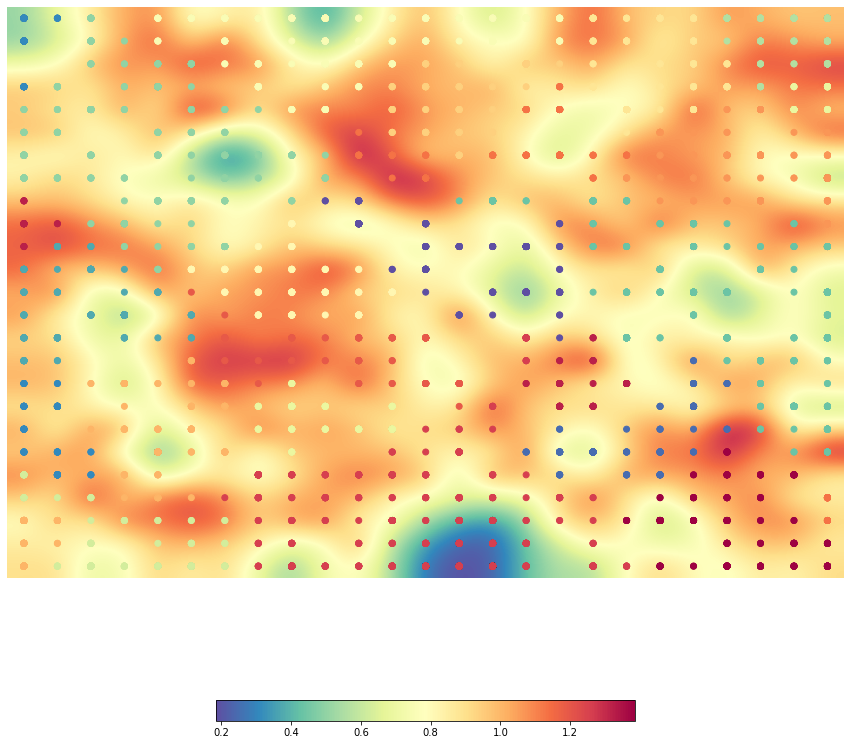

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15,15))

---------

In [ ]:
n_rows, n_columns = 5, 5
if file_exists("som1"):
  som1=load_file("som1");
else: 
  som1 = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
  save_file("som1",som1)

In [ ]:
if file_exists("train1"):
  train1= load_file("train1")
else:
  %time train1=som1.train(final_set[:500,:], epochs = 10)
  save_file("train1", train1)

CPU times: user 623 ms, sys: 4.9 ms, total: 628 ms
Wall time: 332 ms


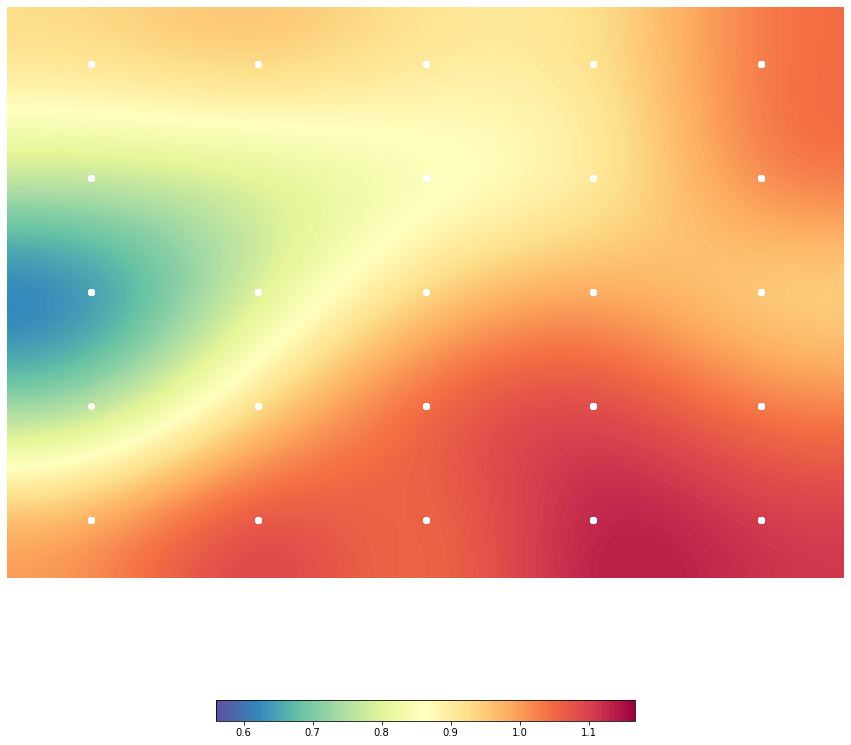

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som1.view_umatrix(bestmatches=True, colorbar=True, figsize=(15,15))

---

In [ ]:
n_rows, n_columns = 30, 30
if file_exists("som3"):
  som3=load_file("som3");
else: 
  som3 = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
  save_file("som3",som3)

In [ ]:
if file_exists("train3"):
  train3= load_file("train3")
else:
  %time train3=som3.train(final_set[:5000,:], epochs = 100)
  save_file("train3", train3)

CPU times: user 37min 55s, sys: 6.45 s, total: 38min 2s
Wall time: 19min 27s


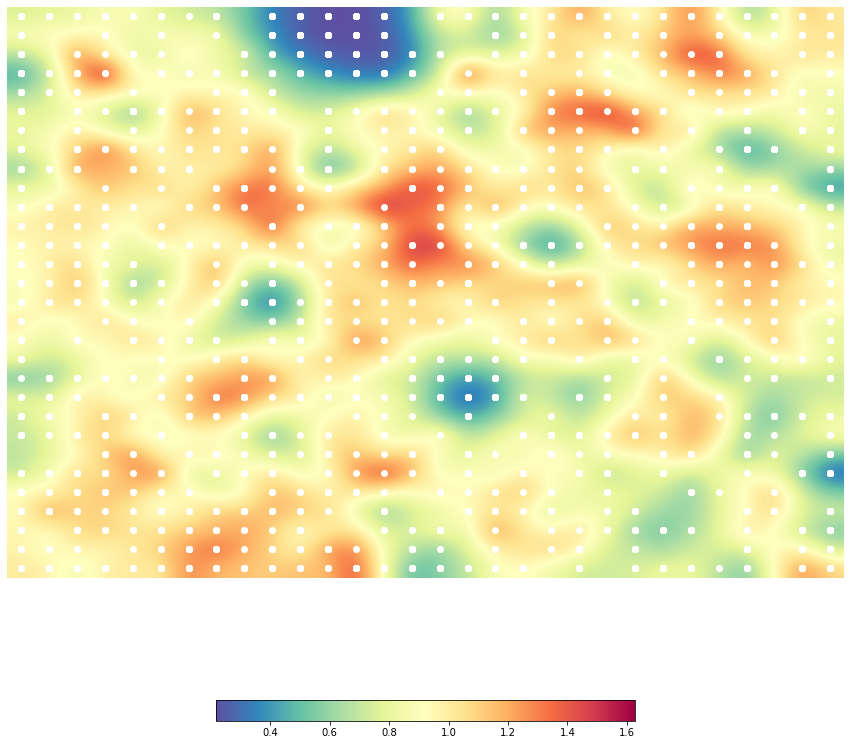

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som3.view_umatrix(bestmatches=True, colorbar=True, figsize=(15,15))

----

In [ ]:
n_rows, n_columns = 40, 40
if file_exists("som4"):
  som4=load_file("som4");
else: 
  som4 = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
  save_file("som4",som4)

In [ ]:
if file_exists("train4"):
  train4= load_file("train4")
else:
  %time train4=som4.train(final_set[:5000,:], epochs = 100)
  save_file("train4", train4)

CPU times: user 1h 10min 29s, sys: 11.8 s, total: 1h 10min 41s
Wall time: 36min 23s


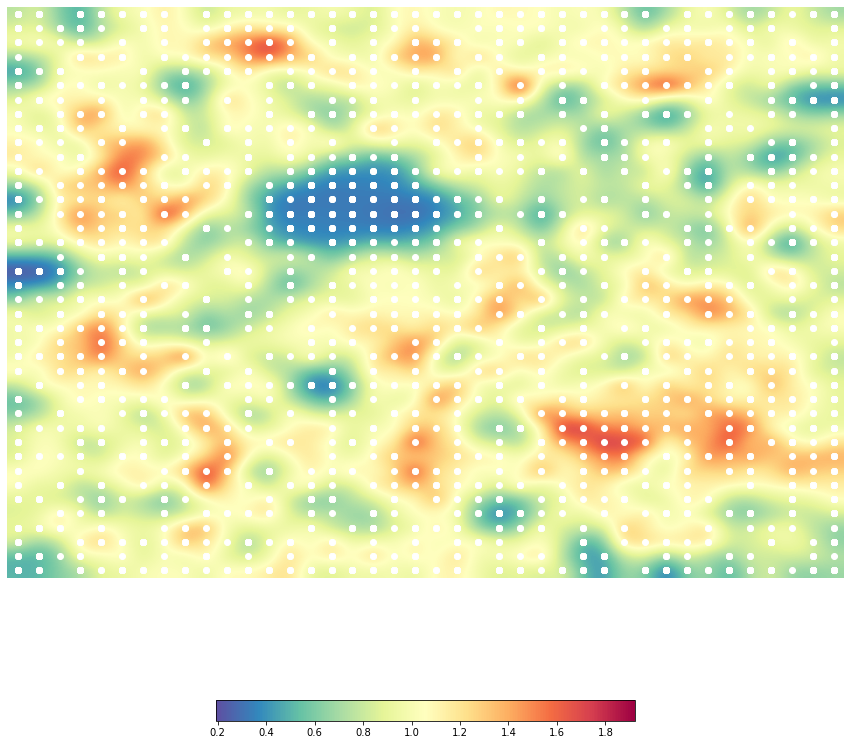

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som4.view_umatrix(bestmatches=True, colorbar=True, figsize=(15,15))

----

In [ ]:
n_rows, n_columns = 32, 32
if file_exists("som5"):
  som5=load_file("som5");
else: 
  som5 = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
  save_file("som5",som5)

In [ ]:
if file_exists("train5"):
  train5= load_file("train5")
else:
  %time train5=som5.train(final_set[:5000,:], epochs = 100)
  save_file("train5", train5)

CPU times: user 43min 3s, sys: 6.52 s, total: 43min 10s
Wall time: 22min 2s


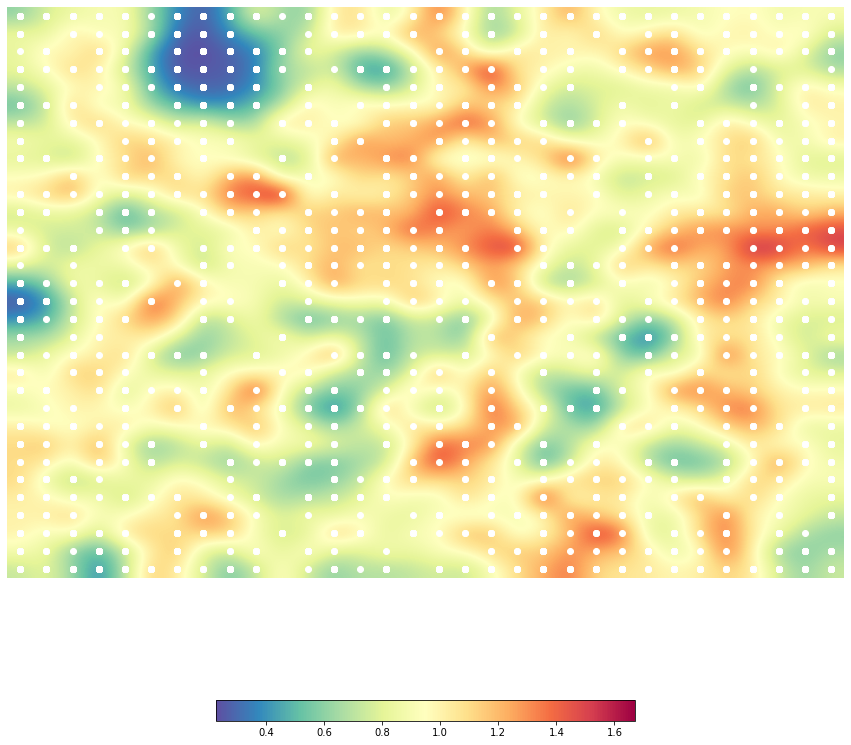

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som5.view_umatrix(bestmatches=True, colorbar=True, figsize=(15,15))

## Best matching units

Μετά από κάθε εκπαίδευση αποθηκέυουμε σε μια μεταβλητή τα **best matching units (bmus)** για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία.  **Προσοχή:** η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της **np.unique** αποθηκεύoυμε τα μοναδικά **best matching units** και τους δείκτες τους (indices) προς τις ταινίες. Είναι πιθανό να έχουμε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θεωρούμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.

In [ ]:
bmus = som.bmus
# bmus = np.flip(bmus, axis=1) # allagi se grammi, stili
# print(bmus[:10][:])
# print(np.flip(bmus, axis=1)[:10][:]) # flip rows

ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
# print(ubmus)
# print(indices)
# len(ubmus)

## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι **μπλε περιοχές αποτελούν clusters** και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην συγκεκριμένη περίπτωση, θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό χάρτη, δοκιμάζουμε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [ ]:
from sklearn.cluster import KMeans
if file_exists("k_means"):
  algorithm = load_file("k_means")
else: 
  algorithm = KMeans(n_clusters = 20)

In [ ]:
som.cluster(algorithm=algorithm)
clusters = som.clusters
print(clusters)

[[ 2  2  5  5  9  9  9  9  9  9  9  9  9  9  9  9  9 11 11 11 11  6  6  6
   6]
 [ 2  2  5  5  9  9  9  9  9  9  9  9  9  9  9  9  9 11 11 11 11  6  6  6
   6]
 [ 2  2  5  5  5  5  9  9  9  9  9  9 12 12 12 12 12 11 11 11 11 11  6  6
   6]
 [ 2  5  5  5  5  5  5  9  9  9  9 12 12 12 12 12 15 11 11 11 11 11  6  8
   8]
 [ 5  5  5  5  5  5  5  5  9  9  9 12 12 12 12 15 15 15 11 11 11 14 14  8
   8]
 [ 5  5  5  5  5  5  5  5  5  9 15 12 12 12 12 15 15 15 11 14 14 14 14 14
  14]
 [ 5  5  5  5  5  5  5  5  5  5 15 15 15 12 15 15 15 15 15 14 14 14 14 14
  14]
 [ 5  5  5  5  5  5  5  5  5  5  5 15 15 15  4 15 15 15 14 14 14 14 14 14
  14]
 [18  5  5  5  5  5  5  5  5  0  0  0  0  4  4  4  4  4  4 14 14 14 14 14
  14]
 [18 18  5  5  5  5  5 10 10  0  0  0  0  0  0  0  0  4  4  4  4  4  4  4
  14]
 [18  3  3  5  5  5  5 10 10 10  0  0  0  0  0  0  0  4  4  4  4  4  4  4
   4]
 [ 3  3  3  3  5 10 10 10 10 10 10  0  0  0  0  0  0  4  4  4  4  4  4  4
   4]
 [ 3  3  3  3  3 16 10 10 10 10 10 10  0

## Αποθήκευση του SOM



Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για την αποθήκευση ενός συγκεκριμένου som και clustering χρησιμοποιούμε και πάλι την `joblib`. 

Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.

In [ ]:
joblib.dump(som, 'som.pkl')

['som.pkl']

## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters



Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">


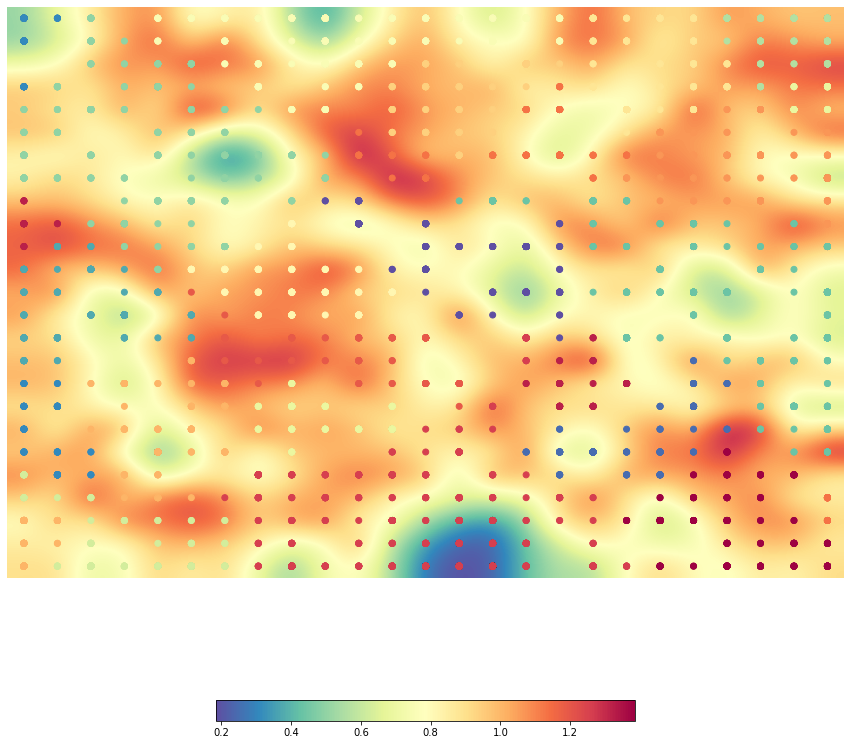

Cluster that each neuron belongs:
 [[ 2  2  5  5  9  9  9  9  9  9  9  9  9  9  9  9  9 11 11 11 11  6  6  6
   6]
 [ 2  2  5  5  9  9  9  9  9  9  9  9  9  9  9  9  9 11 11 11 11  6  6  6
   6]
 [ 2  2  5  5  5  5  9  9  9  9  9  9 12 12 12 12 12 11 11 11 11 11  6  6
   6]
 [ 2  5  5  5  5  5  5  9  9  9  9 12 12 12 12 12 15 11 11 11 11 11  6  8
   8]
 [ 5  5  5  5  5  5  5  5  9  9  9 12 12 12 12 15 15 15 11 11 11 14 14  8
   8]
 [ 5  5  5  5  5  5  5  5  5  9 15 12 12 12 12 15 15 15 11 14 14 14 14 14
  14]
 [ 5  5  5  5  5  5  5  5  5  5 15 15 15 12 15 15 15 15 15 14 14 14 14 14
  14]
 [ 5  5  5  5  5  5  5  5  5  5  5 15 15 15  4 15 15 15 14 14 14 14 14 14
  14]
 [18  5  5  5  5  5  5  5  5  0  0  0  0  4  4  4  4  4  4 14 14 14 14 14
  14]
 [18 18  5  5  5  5  5 10 10  0  0  0  0  0  0  0  0  4  4  4  4  4  4  4
  14]
 [18  3  3  5  5  5  5 10 10 10  0  0  0  0  0  0  0  4  4  4  4  4  4  4
   4]
 [ 3  3  3  3  5 10 10 10 10 10 10  0  0  0  0  0  0  4  4  4  4  4  4  4
   4]
 [ 3 

In [ ]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

print('Cluster that each neuron belongs:\n', clusters)

clusters_sorted = np.unique(clusters, return_index = True, return_counts = True)
# print(clusters_sorted)
print('Clusters in increasing order:\n',clusters_sorted[0])
print('Cluster start index:\n',clusters_sorted[1])
print('Neurons per cluster:\n',clusters_sorted[2])

## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```

In [ ]:
def print_categories_stats(movie_ids):
  n_movies = len(movie_ids)
  all_categories = []
  for movie_id in movie_ids:
    movie_categories = categories[movie_id][0].split(",  ")
    movie_categories = [x.replace('"', '') for x in movie_categories]
    all_categories.extend(movie_categories)
  all_unique_categories, counts_unique_categories = np.unique(all_categories, return_counts = True)
  sorted_indices = reversed(np.argsort(counts_unique_categories))
  print('-'*100)
  print('{:<40} |   {:<30}   |   {:<8}(total: {})'.format('Category', 'Percentage %', 'Counts', n_movies))
  print('-'*100)
  for idx in sorted_indices:
    print('{:<40} |   {:<30}   |   {:<5}'.format( all_unique_categories[idx], counts_unique_categories[idx]/n_movies, counts_unique_categories[idx] ))
  return

# print_categories_stats(list(range(0,500)))

In [ ]:
# return movie_ids associated with the specific neuron
def neuron_movies_report(neuron_ids):
  movie_ids = []
  for neuron_id in neuron_ids:
    movies_ids_part = np.where(indices == neuron_id)[0]
    movie_ids.extend(movies_ids_part)
  # print(movie_ids)
  return movie_ids

# neuron_movies_report(print_cluster_neurons_movies_report(3))

In [ ]:
def equal_arrays(arA, arB):
  if (len(arA) != len(arB)):
    return False
  for idx in range(0,len(arA)):
    if arA[idx] != arB[idx]:
      return False
  return True

# return neuron_ids associated with the specific cluster
def print_cluster_neurons_movies_report(cluster_id):
  neuron_coords_of_cluster = np.where(clusters == cluster_id) # coords (column-) of neurons of cluster with input id
  neuron_coords_of_cluster = np.column_stack((neuron_coords_of_cluster[0], neuron_coords_of_cluster[1]))
  # print(neuron_coords_of_cluster)
  # print(ubmus)
  neuron_ids_of_cluster = []
  for i in neuron_coords_of_cluster:
    for u_idx in range(0, len(ubmus)):
      if equal_arrays(i, ubmus[u_idx]):
        neuron_ids_of_cluster.append(u_idx)
  neuron_ids_of_cluster = np.array(neuron_ids_of_cluster)
  # print(neuron_ids_of_cluster)
  print('='*100)
  print('\n','Cluster with number', cluster_id, '\n')
  movie_ids = neuron_movies_report(neuron_ids_of_cluster)
  print_categories_stats(movie_ids)
  return neuron_ids_of_cluster

# print(indices)
# print(bmus)
# print(clusters)

In [ ]:
for i in range(0, n_clusters):
  print_cluster_neurons_movies_report(i)


 Cluster with number 0 

----------------------------------------------------------------------------------------------------
Category                                 |   Percentage %                     |   Counts  (total: 64)
----------------------------------------------------------------------------------------------------
Short Film                               |   1.0                              |   64   
Animation                                |   0.796875                         |   51   
Comedy film                              |   0.21875                          |   14   
Animated cartoon                         |   0.09375                          |   6    
Family Film                              |   0.078125                         |   5    
Computer Animation                       |   0.0625                           |   4    
Drama                                    |   0.03125                          |   2    
Science Fiction                          |   0.03125  

## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering έχουμε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής μας. Για ευκολία ξανατυπώνουμε το uMatrix καθώς και τον πίνακα των clusters:

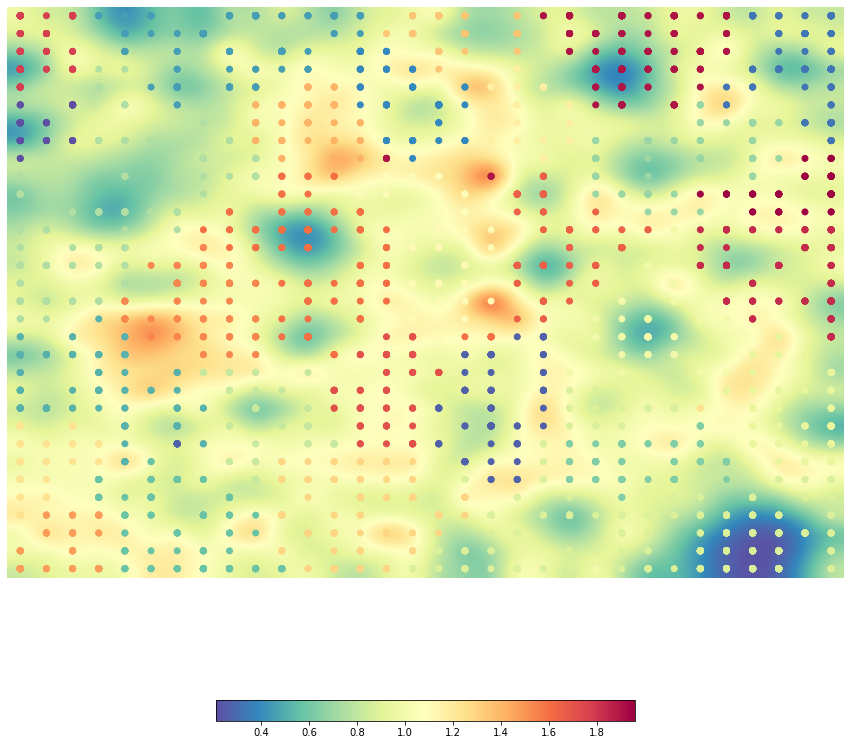

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [ ]:
# force to print whole array
np.set_printoptions(threshold=np.inf)

# print cluster per neuron in array style
print('Cluster that each neuron belongs:\n', clusters)

# print amount of neurons per cluster
print('Amount of neurons per cluster:\n',clusters_sorted[2])

Cluster that each neuron belongs:
 [[26 26 26  4  4  4  4  4  4  4  4  4  4  4 19 19 19 19 19 19 28 28 28 28
  28 28 28 28  2  2  2  2]
 [26 26 26  4  4  4  4  4  4  4  4  4  4  4 19 19 19 19 19 19 28 28 28 28
  28 28 28 28  2  2  2  2]
 [26 26 26  9  4  4  4  4  4  4  4  4  3  3  3 19 19 19 19 19 28 28 28 28
  28 28 28 28  2  2  2  2]
 [26 26 26  9  9  4  4  4  4  4  4  4  3  3  3  3 19 19 16 16 16 28 28 28
  28 28 28  2  2  2  2  2]
 [26 26  0  9  9  4  4  4  4  4 20 20 20  3  3  3  3  3 16 16 16 16 28 28
  28 28 28  2  2  2  2  2]
 [ 0  0  0  0  9  9  4  9  4 20 20 20 20  3  3  3  3  3 16 16 16 16 28 28
  28 28  8  2  8  8  2  2]
 [ 0  0  0  9  9  9  9  9  9 20 20 20 20 20  3  3  3  3 16 16 16 16 16 28
   8  8  8  8  8  8  2  2]
 [ 0  0  0  9  9  9  9  9  9 20 20 20 20 20  3  3  3  3 16 16 16 16  8  8
   8  8  8  8  8  8  2  2]
 [ 0  0  9  9  9  9  9  9  9  9 20 20 20 20 28  3 14  3 16 16 16  8  8  8
   8  8  8  8  8  8 29 29]
 [ 9  9  9  9  9  9  9  9  9  9 23 23 23 14 14 14 14 14 

```
[26 26 26  4  4  4  4  4  4  4  4  4  4  4 19 19 19 19 19 19 28 28 28 28 28 28 28 28  2  2  2  2]
[26 26 26  4  4  4  4  4  4  4  4  4  4  4 19 19 19 19 19 19 28 28 28 28 28 28 28 28  2  2  2  2]
[26 26 26  9  4  4  4  4  4  4  4  4  3  3  3 19 19 19 19 19 28 28 28 28 28 28 28 28  2  2  2  2]
[26 26 26  9  9  4  4  4  4  4  4  4  3  3  3  3 19 19 16 16 16 28 28 28 28 28 28  2  2  2  2  2] 
[26 26  0  9  9  4  4  4  4  4 20 20 20  3  3  3  3  3 16 16 16 16 28 28 28 28 28  2  2  2  2  2]
[ 0  0  0  0  9  9  4  9  4 20 20 20 20  3  3  3  3  3 16 16 16 16 28 28 28 28  8  2  8  8  2  2]
[ 0  0  0  9  9  9  9  9  9 20 20 20 20 20  3  3  3  3 16 16 16 16 16 28 8  8  8  8  8  8  2  2]
[ 0  0  0  9  9  9  9  9  9 20 20 20 20 20  3  3  3  3 16 16 16 16  8  8 8  8  8  8  8  8  2  2]
[ 0  0  9  9  9  9  9  9  9  9 20 20 20 20 28  3 14  3 16 16 16  8  8  8 8  8  8  8  8  8 29 29]
[ 9  9  9  9  9  9  9  9  9  9 23 23 23 14 14 14 14 14 28 24 24  8  8  8 8  8  8  8  8 29 29 29]
[ 9  9  9  9  9  9  9  9 23  9 23 23 23 14 14 14 14 14 28 24 24 24  8  8 8  8 29 29 29 29 29 29]
[ 9  9  9  9  9  9  9  9 23 23 23 23 23 23 14 14 14 14 14 24 24 24 24  8 8  8  8 27 29 29 29 29]
[ 9  9  9  9  9  9  9 23 23 23 23 23 23 23 23 15 15 15 15 28 24 24 24 24 24 13 27 27 27 27 27 27]
[ 9  9  9  9  9  9 22 22 23 23 23 23 23 23 23 15 15 15 15 24 24 24 24 24 24 13 27 27 27 27 27 27]
[ 9  9  9  9  9 22 22 22 22 22 23 23 23 23 23 15 15 15 15 24 24 24 24 24 13 13 27 27 27 27 27 27]
[ 9  9  9  9  9 22 22 22 22 22 23 23 23 23 23 15 15 15 15 24 24 24 24 13 13 13 27 27 27 27 27 27] 
[ 9  9  9  9 22 22 22 22 22 22 23 23 23 23 23 15 15 15 15 24 24 24 13 13 13 13 13 27 27 27 27 27]
[ 9  9  9  5 22 22 22 22 22 22 23 23 23 23 23 15 15 15 23 24 24 13 13 13 13 13 13 13 27 27 27 27]
[ 5  5  5  5  5 22 22 22 22 22 23 23 23 25 25 25 15 23 23  1  1 13 13 13 13 13 13 13 13 12 12 27]
[ 5  5  5  5  5  5 22 22 22 22 23 23 23 25 25 25 25  1  1  1  1 13 13 13 13 13 13 13 12 12 12 12]
[ 5  5  5  5  5  5  5 10 10 10 10 10 25 25 25 25 25  1  1  1  1 13 13 13 13 13 13 13 12 12 12 12]
[ 5  5  5  5  5  5  5 10 10 10 10 10 25 25 25 25  1  1  1  1  1 11 11 11 11 11 11 12 12 12 12 12]
[ 5  5  5  5  5  5  5  5 10 10 10 10 25 25 25 25  1  1  1  1  1 11 11 11 11 11 17 12 12 12 12 12] 
[17 17 17 17  5  5  5 10 10 10 10 10 10 25 25 25  1  1  1  1  1 11 11 11 11  7  7  7 12 12 12 12]
[17 17 17 17  5  5  1  5 10 10 10 10 10 25 25 25  1  1  1  1 11  7  7  7 7  7  7  7 12 12 12 12]
[17 17 17 17  5  6  6  6 10 10 18 18 18 18 18 18  1  1  1  1 11  7  7  7 7  7  7  7  7 12 12 12]
[17 17 17  6  6  6  6  6 10 10 18 18 18 18 18 18 18 11  1  1 11  7  7  7 7  7  7  7 11 11 11 11]
[17 17 21  6  6  6  6  6  6 10 18 18 18 18 18 18 18 18 11 11 11 11 11  7 11 11 11 11 11 11 11 11]
[17 21 21 21  6  6  6  6  6  6 18 18 18 18 18 18 18 18 11 11 11 11 11 11 11 11 11 11 11 11 11 11]
[21 21 21 21  6  6  6  6  6  6 18 18 18 18 18 18 18 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11] 
[21 21 21 21  6  6  6  6  6  6 18 18 18 18 18 18 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11]
[21 21 21 21  6  6  6  6  6  6  6 18 18 18 18 11 11 11 11 11 11 11 13 11 11 11 11 11 11 11 11 11]]
```

#### Παρακάτω φαίνεται κάθε cluster με τις δύο πιο κοινές κατηγορίες:

cluster  | first  category| percentage | count | second category | percentage | count
---|----|----|---|----|---|---
0| Horror|   0.61|   148 | Documentary|   0.38|   91
1| Drama|   0.81|   156 | Musical|   0.53|   103
2| Drama|   1.0|   205|Thriller|   0.98|   200
3| Comedy|   0.99|   136 | Short Film|   0.74|   102
4| Drama|   1.0|   98|Family Drama|   0.54|   53
5| Horror|   0.81|   151| Japanese Movies|   0.22|   40
6| Drama|   1.0|   712 | Romance Film|   0.19|   134
7| Drama|   0.92|   125 | Crime Fiction|   0.72|   98
8| Fantasy|   0.77|   71| Animation|   0.48|   44
9| Comedy|   0.86|   123|Drama|   0.64|   91
10| Short Film|   0.85|   168|Animation|   0.27|   54
11| Drama|   0.97|   367|Romance Film|   0.64|   240
12| Adventure|   0.91|   53|Drama|   0.90|   52
13| Drama|   0.51|   78 | Comedy|   0.51|   77
14| Comedy|   1.0|   247| Parody|   0.14|   35
15| Action|   1.0|   57| Action/Adventure|   0.842|   48
16| Drama|   0.65|   112|Period piece|   0.27|   46
17| Comedy|   0.99|   194|Romance Film|   0.72|   140
18| Thriller|   0.25|   82| Silent film|   0.14|   47
19| Romance Film|   0.83|   63| Action|   0.32|   24
20| Action|   0.97|   114| Adventure|   0.64|   75
21| Thriller|   1.0|   107| Horror|   0.87|   93
22| Comedy|   0.85|   45| Family Film|   0.72|   38
23| Action|   0.825|   66 | Action/Adventure|   0.8|64
24| Drama|   0.57|   82|Comedy|   0.50|   72
25| Thriller|   0.95|   53| Action|   0.80|   45
26| Family Film|   0.89|   50 |Comedy|   0.46|   26
27| Animation|   0.66|   128| Comedy film|   0.54|   105
28| Action/Adventure|   0.99|   104| Action|0.95|100
29| Adventure|   0.98|   82 | Family Film |   0.30|   25

#### Γενικά

Από το umatrix παρατηρούμε μεγάλες περιοχές μπλε-πράσιονου χρώματος, που περιβάλλονται από κιτνρινό-κόκκινες καμπύλες. Αυτό εκφράζει κοντινούς ομαδοποιημένους γείτονες που έχουν ξεκάθαρα σύνορα με τις υπόλοιοπες ομάδες. Επίσης υπάρχουν ελάχιστες περιοχές με έντονο κόκινο χρώμα, που υποδεικνύουν απομακρυσμένους γείτονες. Συνεπώς ο διαχωρισμός μας σε clusters είναι πολύ καλός.

**Η ομοιότητα των ταινιών ανά cluster αγγίζει κυρίως ποσοστά 90%-100%** (στην κυριότερη κατηγορία), πράγμα που μας δείχνει ότι η ομαδοποίηση μας είναι σωστή. Υπάρχει **μόνο 1 cluster με ποσοστό μικρότερο του 50%** (το cluster 18 που θα αναφερθούμε στην συνέχεια). Ακόμη παρατηρούμε πως τα μεγέθη των ομάδων είναι αρκετά μεγάλα, δηλαδή δεν υπάρχουν ομάδες με τετριμμένα μικρό μέγεθος (πχ 20-30 ταινίες). Αυτό είναι πολύ σημαντικό για να θεωρούμε την ομαδοποίηση μας ουσιώδη.

Τα παραπάνω επιτεύχθηκαν με σωστή επιλογή παραμέτρων τόσο για το μέγεθος του SOM όσο και για τον αριθμό των clusters (που προσσεγιαστικά επιλέξαμε παρατηρώντας το umatrix).

Αξίζει να σημειωθεί πως τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας. Συνεπώς δεν γίνεται όλα τα ποσοστά να είναι στο 100%.

#### Διαδικασία Βελτιστοποίησης

Αρχικά, ακολουθήσαμε μια διαδικασία για να βελτιώσουμε το αριθμό νευρώνων του χάρτη Som ανά γραμμή και ανά στήλη. Για να συγκρίνουμε τα αποτελέσματα των διαφορετικών παραμέτρων ελέγχαμε κατά πόσο η μορφή του uMatrix ήταν αρκετά επιθυμητή (πολλές μπλε-πράσινες περιοχές, λίγες κιτρινο-κόκκινες). 
Για τις παραμέτρους n_rows, n_columns δοκιμάσαμε (20,20), (23,23), (25,25), (28,28), (30,30), (35,35). Τα αποτελέσματα ήταν βέλτιστα στην περιπτώση των ζευγών (28,28) και παραπάνω. Κρατήσαμε τους λιγότερους νευρώνες για να επιταχύνουμε τον υπολογισμό του som και να μειώσουμε το μέγεθος της μνήμης που καταλαμβάνει.

Ένα ενδεικτικό καλής ομαδοποίησης που παρατηρούμε είναι ότι οι δύο κατηγορίες με την μεγαλύτερη συχνότητα για κάθε cluster έχουν μεγάλη συνάφεια. Για παράδειγμα: 
- το cluster 2 έχει κύριες κατηγορίες Drama και Thriller	
- το cluster 15 έχει κύριες κατηγορίες Action και Action/Adventure	
- το cluster 22 έχει κύριες κατηγορίες Comedy και Family Film	

Ταυτόχρονα όμως, το ζευγάρι των συχνότερων κατηγοριών δεν είναι πάντα το ίδιο. Για παράδειγμα:
- το cluster 3 έχει κύριες κατηγορίες Comedy, Short Film
- ενώ το cluster 14 έχει κύριες κατηγορίες Comedy, Parody
- το cluster 19 έχει κύριες κατηγορίες Romance Film, Action
- ενώ το cluster 11 έχει κύριες κατηγορίες Drama, Romance Film		


#### Η πυκνότητα πιθανότητας στο χώρο εισόδου επηρεάζει το πλήθος των κόμβων

Αρχικά παρατηρούμε ότι οι ταινίες που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Για παράδειγμα:
- οι περισσότερες ταινίες ανήκουν στην κατηγορία Drama. Συνεπώς υπάρχουν πολλά clusters από νευρώνες που έχουν το Drama ως κυρίαρχη κατηγορία. Αυτό οδηγεί στο να συγκεντώνονται ομάδες με κατηγορία Drama σε διάφορες περιοχές του χάρτη. Συγκεκριμένα, τα clusters 2, 11  βρίσκονται στο πάνω μέρος του χάρτη. Το cluster 1 στο κάτω μέρος του χάρτη. Τα clusters 4, 6, 16 στο κάτω δεξιά μέρος. 
- αντίθετα, λιγότερες ταινίες ανήκουν στην κατηγορία Short Film και Animation. Παρατηρούμε ότι μόνο τα cluster 10, 27 έχουν αυτές ως κύριες κατηγορίες και είναι τοποθετημένα στο αριστερά μέρος του χάρτη.

#### Μακρινά πρότυπα εισόδου εμφανίζονται απομακρυσμένα και στον χάρτη του SOM

Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη. Για παράδειγμα:

- οι ταινίες comedy, family film, animation είναι τοποθετημένες στο αριστερά μέρος του χάρτη (clusters 10, 14, 17, 3, 27) ενώ αντίθετα
- οι ταινίες drama, thriller είναι τοποθετημένες στο πάνω και πάνω δεξιά μέρος του χάρτη (clusters 11, 2) ενώ οι drama, comedy, romance film (οι λίγο πιο χαλαρές drama θα λέγαμε) στο κάτω δεξιά (clusters 6, 16, 24).


- οι ταινίες horror, thriller είναι τοποθετημένες στο πάνω αριστερά μέρος του χάρτη και προς το κέντρο του (clusters 0, 21, 18) ενώ αντίθετα
- οι ταινίες action, adventure είναι τοποθετημένες στο κέντρο του χάρτη (clusters 28, 12, 23, 20).

#### Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. 

Παρατηρούμε επίσης ότι οι νευρώνες των ταινιών που έχουν κοινές κατηγορίες συνορεύουν αντίστοιχα και στο χάρτη Som. Με άλλα λόγια οι γειτονικές περιοχές στον χάρτη έχουν σημασιολογική συνάφεια.

Για παράδειγμα, στο πάνω αριστερά μέρος:
- το cluster 0 έχει κύριες κατηγορίες Horror 	
- γειτονικό του είναι το cluster 5 που έχει επίσης κύρια κατηγορία Horror μαζί με Japanese Movies
- γειτονικό του είναι το cluster 21 που έχει κύριες κατηγορίες Horror και Thriller
- γειτονικό των 0 και 21 είναι το cluster 18 που έχει κατηγορία Thriller 
- ουσιατικά είναι μαζεμένες οι ταινίες μυστηρίου-αγωνίας

Στο κέντρο:
- το cluster 20 έχει κύρια κατηγορία Action, Adventure		
- γειτονικά του είναι τα cluster 23 και 28 που έχει ακριβώς ίδιες κατηγορίες 
- ουσιατικά στο κέντρο είναι μαζεμένες οι ταινίες δράσης

Στο αριστερό μέρος του χάρτη:
- το cluster 27 έχει κύρια κατηγορία animation
- γειτονικό του προς τα αριστερά είναι το cluster 10 που έχει κύριες κατηγορίες Short Film και Animation
- γειτονικό του προς τα δεξιά (κοντά στο κέντρο) είναι το cluster 8 που έχει κύριες κατηγορίες Fantasy Animation
- το εντυπωσιακό είναι πως οι ταινίες φαντασίας συχνά έχουν πολλή δράση και στο χάρτη το cluster 8 συνορεύει επίσης με τα κεντρικά clusters που ομαδοποιούν ταινίες δράσης
- ουσιατικά είναι μαζεμένες οι ταινίες φαντασίας και τα κινούμενα σχέδια

Στο κάτω αριστερά μέρος του χάρτη:
- το cluster 3 έχει κύρια κατηγορία comedy
- όλα τα γειτονικά του clusters, δηλαδή 14, 17, 26, 27, έχουν αντίστοιχες κατηγορίες όπως Parody, Family Film, Romance
- ουσιατικά είναι μαζεμένες οι πιο κωμικές και οικογενιακές ταινίες

#### Ιδιαίτερα clusters

Το cluster 18 έχει μεγάλο ενδιαφέρον, καθώς είναι το μόνο με χαμηλό ποσοστό ομαδοποίησης στην κυρίαρχη κατηγορία (Thriller). Είναι ένα σχετικά μεγάλο cluster. Αν παρατηρήσουμε όμως τις συχνότερες κατηγορίες στο σύνολο τους είναι προφανές ότι έχουν μεγάλη συνάφεια μεταξύ τους. Συγκεκριμένα πέρα από Thriller, επόμενες κύριες κατηγορίες είναι Silent film, Mystery, Psychological thriller, Mystery, Crime Thriller. **Συνεπώς η ομαδοποίηση που έχει γίνει είναι πολύ σωστή, όχι όμως τόσο ειδική**. Αναφέρεται γενικότερα σε ταινίες μυστηρίου, αγωνίας, με μεγάλη ένταση για τον θεατή.

#### Σκέψεις

Αξίζει να σημειώσουμε πάλι πως με την χρήση του SOM σε δισδιάστατο χάρτη δεν μπορεί να επιτευχθεί μια απόλυτη τοπολογία. Παρόλα αυτά το SOM αποτελεί ένα πολύ καλό εργαλείο, διότι καταφέρνει σε χώρο δύο διαστάσεων να απεικονίζει όλες τις ταινίες που του αναθέτουμε με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. Μάλιστα το καταφέρνει με γρήγορο τρόπο, ακολουθώντας μια σχετικά απλή λογική. 

Η δική μας υλοποίηση αγγίζει υψηλά ποσοστά ομαδοποίησης σύμφωνα με τη παραπάνω ανάλυση, συνεπώς θα μπορούσε να χρησιμοποιηθεί από οποιονδήποτε για να διαλέξει την επόμενη ταινία που θέλει να παρακολουθήσει!!